In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, accuracy_score

# Load and preprocess the dataset
data = pd.read_csv("top_500_features_ReliefF.csv")
X_500 = (data.iloc[:, :-1] - data.iloc[:, :-1].mean()) / data.iloc[:, :-1].std()  # Normalize
y = OneHotEncoder(sparse_output=False).fit_transform(data.iloc[:, -1].values.reshape(-1, 1))

X_train4, X_test4, y_train4, y_test4 = train_test_split(X_500, y, test_size=0.3, random_state=42)
input_size, output_size = X_train4.shape[1], y_train4.shape[1]

# Define architecture options
architectures = ['CNN_DENSE_MAX', 'ANN_DROPOUT', 'CNN_DENSE_avg', 'CNN_AVG', '1D_CNN']
initializers = ['he_normal', 'glorot_uniform', 'lecun_normal', 'he_uniform', 
                'lecun_uniform', 'glorot_normal', 'orthogonal', 'random_normal', 
                'random_uniform', 'truncated_normal']
best_models = {}
best_histories = {}  # Store best history for each architecture-initializer

# Define model creation function
def create_model(architecture, initializer):
    model = models.Sequential()
    if architecture == 'CNN_DENSE_MAX':
        model.add(layers.Input(shape=(input_size, 1))) 
        model.add(layers.Conv1D(64, kernel_size=3, activation='relu', kernel_initializer=initializer))
        model.add(layers.MaxPooling1D(pool_size=2))
        model.add(layers.Flatten())
        model.add(layers.Dense(64, activation='relu', kernel_initializer=initializer))
    elif architecture == 'ANN_DROPOUT':
        model.add(layers.Input(shape=(input_size,)))
        model.add(layers.Dense(128, activation='relu', kernel_initializer=initializer))
        model.add(layers.Dropout(0.5))
        model.add(layers.BatchNormalization())
        model.add(layers.Dense(64, activation='relu', kernel_initializer=initializer))
        model.add(layers.Dropout(0.5))
        model.add(layers.BatchNormalization())
    elif architecture == 'CNN_DENSE_avg':
        model.add(layers.Input(shape=(input_size, 1))) 
        model.add(layers.Conv1D(64, kernel_size=3, activation='relu', kernel_initializer=initializer))
        model.add(layers.AveragePooling1D(pool_size=2))
        model.add(layers.Flatten())
        model.add(layers.Dense(64, activation='relu', kernel_initializer=initializer))
    elif architecture == 'CNN_AVG':
        model.add(layers.Input(shape=(input_size, 1))) 
        model.add(layers.Conv1D(64, kernel_size=3, activation='relu', kernel_initializer=initializer))
        model.add(layers.AveragePooling1D(pool_size=2))
        model.add(layers.Flatten())
    elif architecture == '1D_CNN':
        model.add(layers.Input(shape=(input_size, 1))) 
        model.add(layers.Conv1D(64, kernel_size=3, activation='relu', kernel_initializer=initializer))
        model.add(layers.MaxPooling1D(pool_size=2))
        model.add(layers.Flatten())
    
    model.add(layers.Dense(output_size, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Perform K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True)
for architecture in architectures:
    best_models[architecture] = {}
    best_histories[architecture] = {}

    for initializer in initializers:
        best_fold_accuracy = 0
        best_fold_loss = float('inf')
        best_fold_history = None
        best_model = None  # To store the best model

        for fold, (train_index, val_index) in enumerate(kf.split(X_train4)):
            model = create_model(architecture, initializer)

            # Early stopping
            early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
            
            history = model.fit(
                X_train4.iloc[train_index], y_train4[train_index],
                validation_data=(X_train4.iloc[val_index], y_train4[val_index]),
                epochs=10, batch_size=32, verbose=1, callbacks=[early_stopping]
            )
            
            # Track the best fold based on validation accuracy and loss
            val_accuracy = history.history['val_accuracy'][-1]
            val_loss = history.history['val_loss'][-1]
            if val_accuracy > best_fold_accuracy or (val_accuracy == best_fold_accuracy and val_loss < best_fold_loss):
                best_fold_accuracy = val_accuracy
                best_fold_loss = val_loss
                best_model = model  # Store the best model
                best_fold_history = history  # Keep the best history for plotting

        # Store the best history and model for this architecture-initializer combination
        best_histories[architecture][initializer] = best_fold_history
        best_models[architecture][initializer] = best_model




2024-11-19 18:43:14.677018: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 295ms/step - accuracy: 0.5551 - loss: 9.8563 - val_accuracy: 0.4667 - val_loss: 7.7320
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.5893 - loss: 4.3652 - val_accuracy: 0.5333 - val_loss: 6.6102
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4732 - loss: 8.7816 - val_accuracy: 0.6667 - val_loss: 3.9274
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7976 - loss: 3.5212 - val_accuracy: 0.6000 - val_loss: 9.6376
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8393 - loss: 2.4708 - val_accuracy: 0.6000 - val_loss: 13.1738
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8408 - loss: 2.4998 - val_accuracy: 0.6000 - val_loss: 13.6191
Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 442ms/step - accuracy: 0.5397 - loss: 3.5267 - val_accuracy: 0.7143 - val_loss: 2.1331
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.6528 - loss: 7.0213 - val_accuracy: 0.7143 - val_loss: 

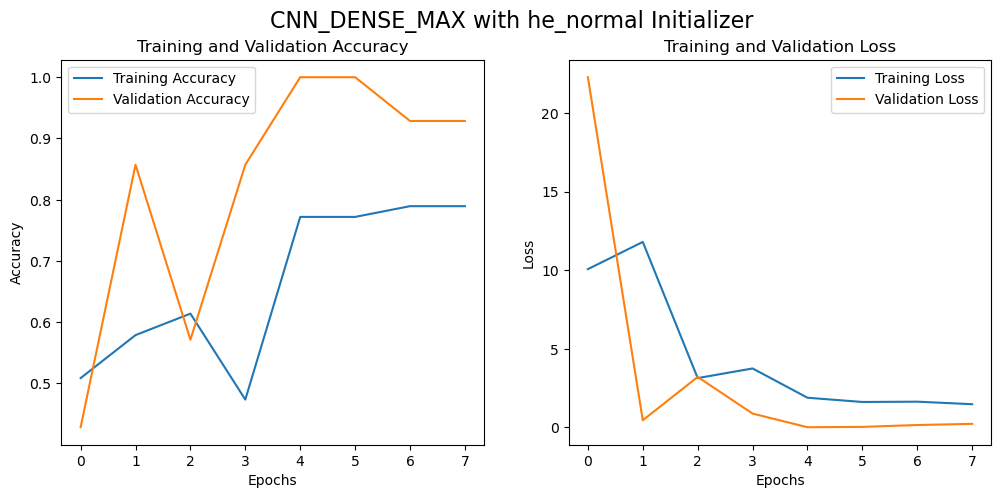

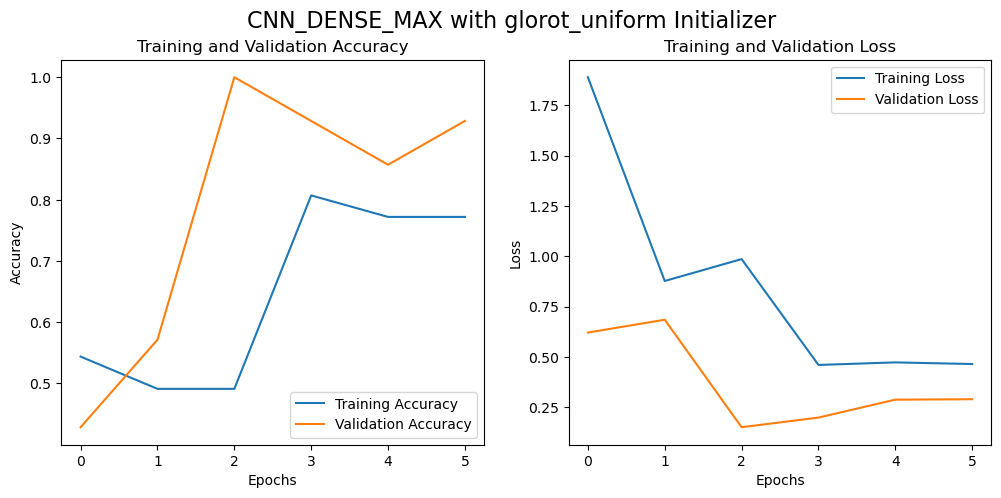

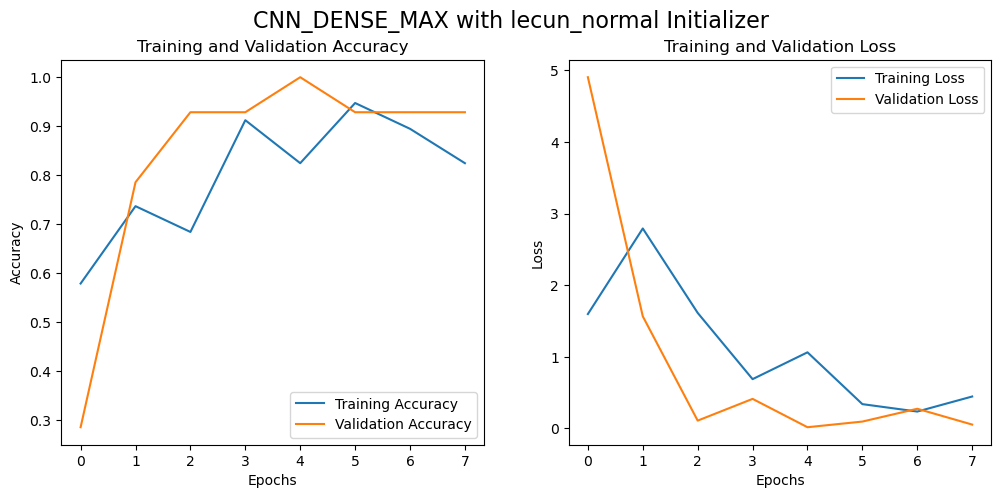

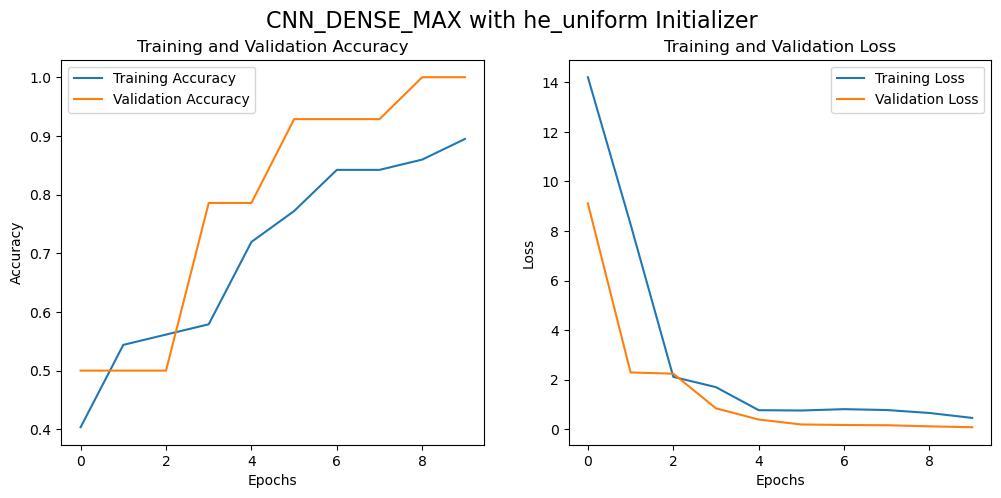

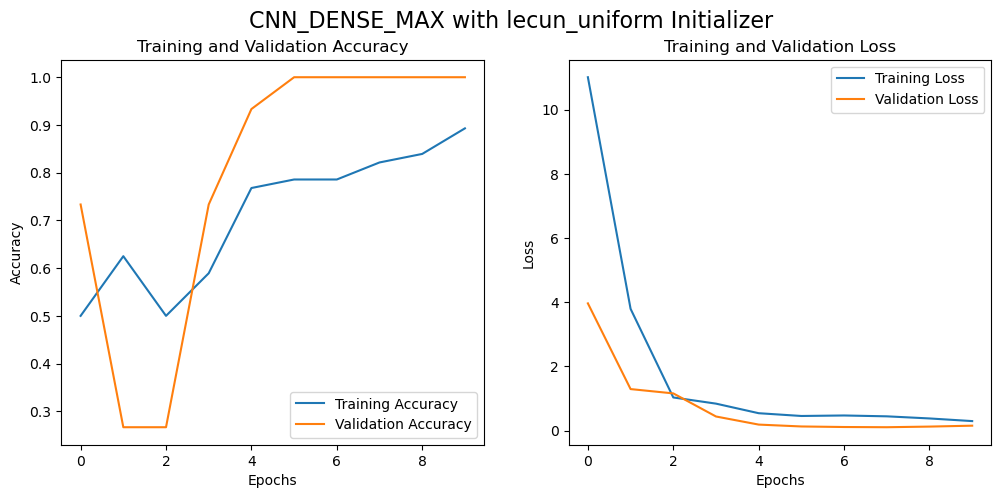

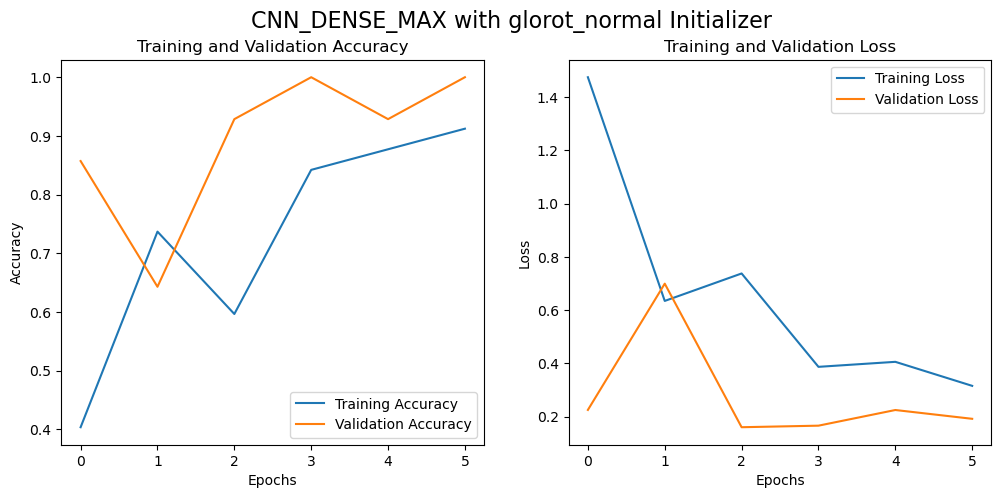

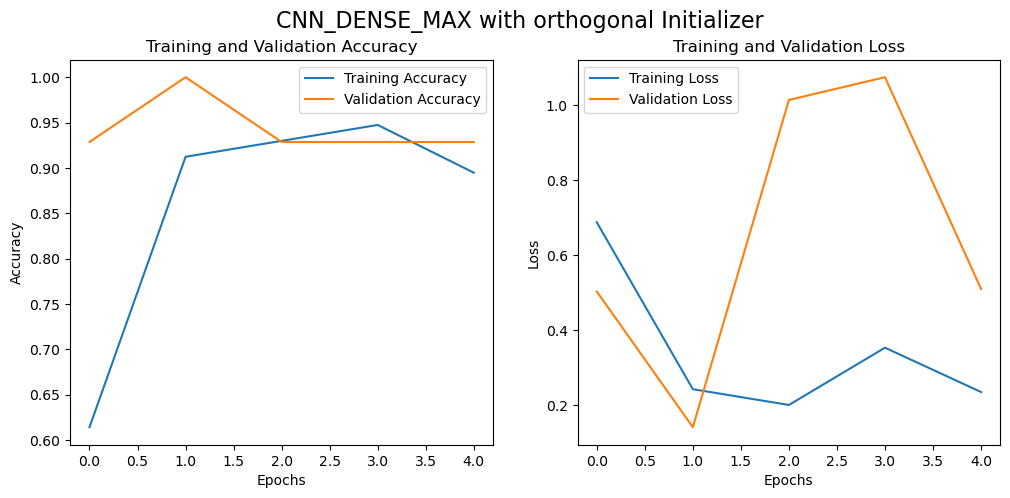

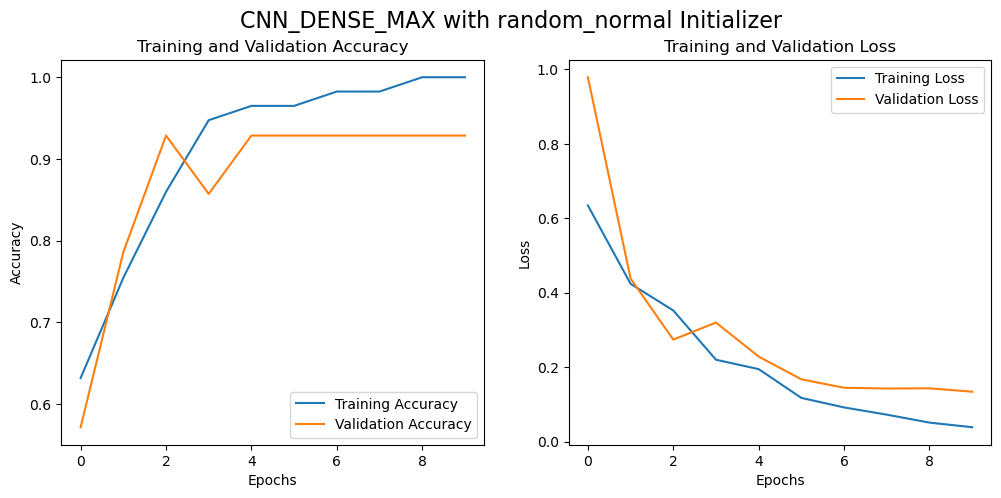

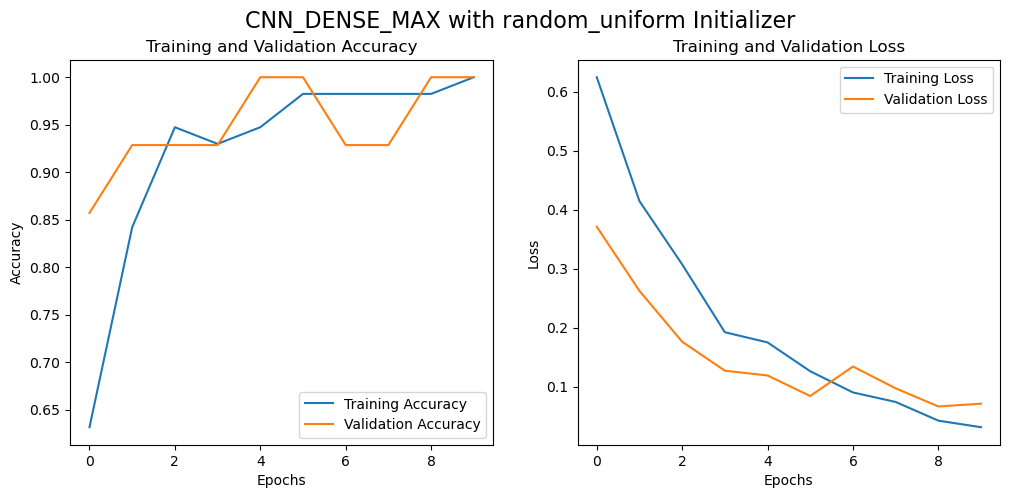

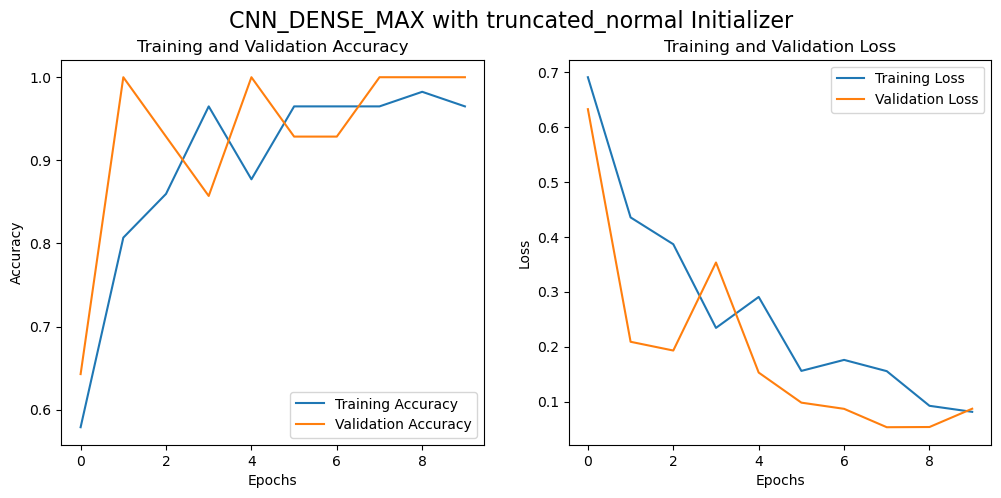

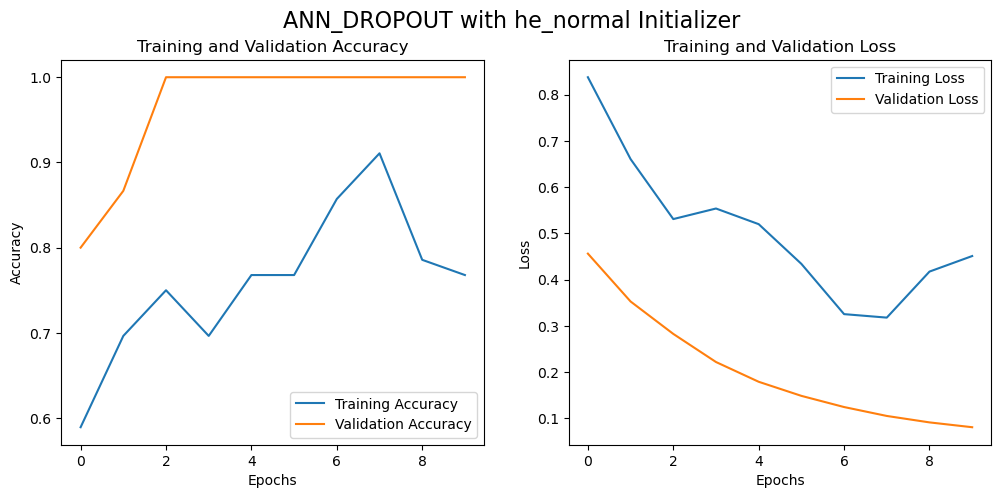

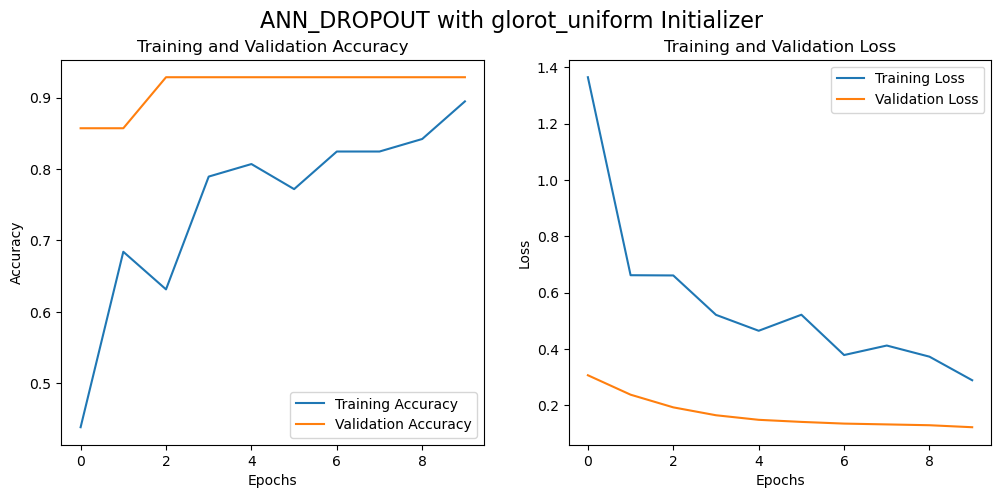

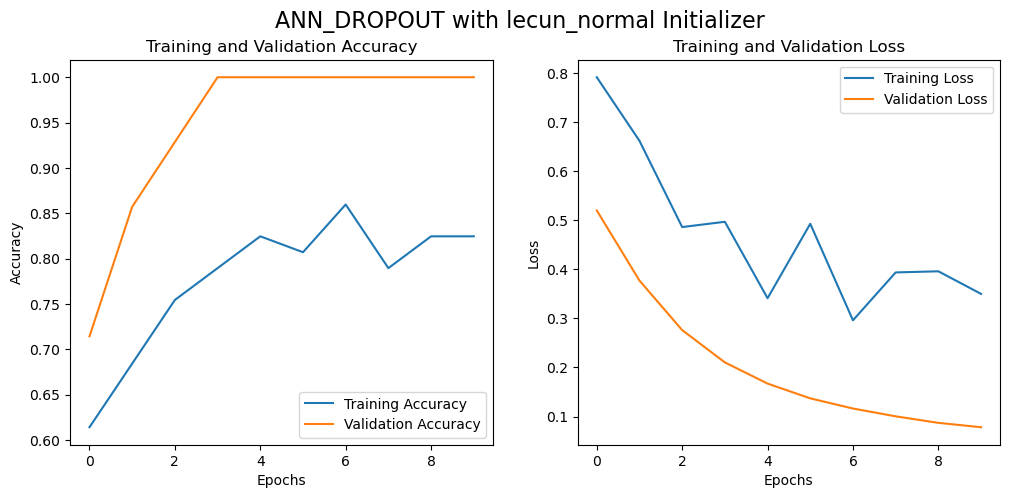

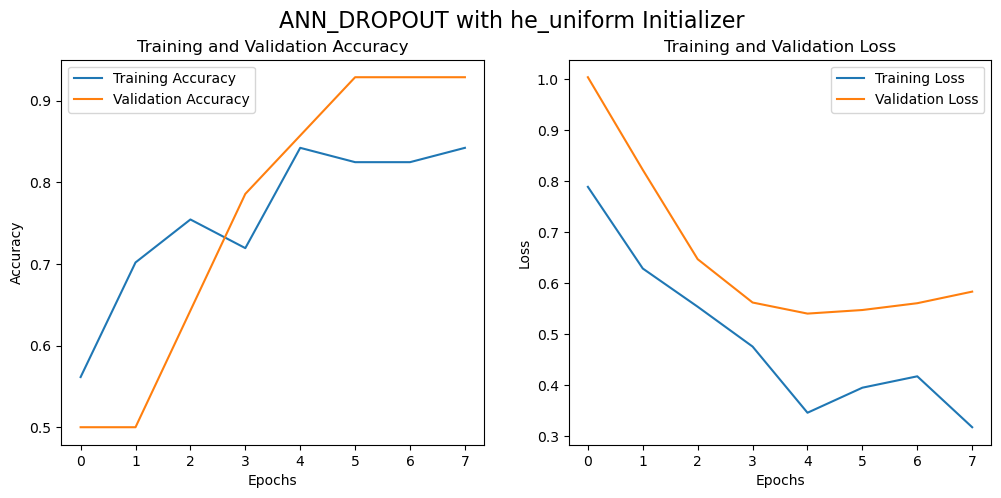

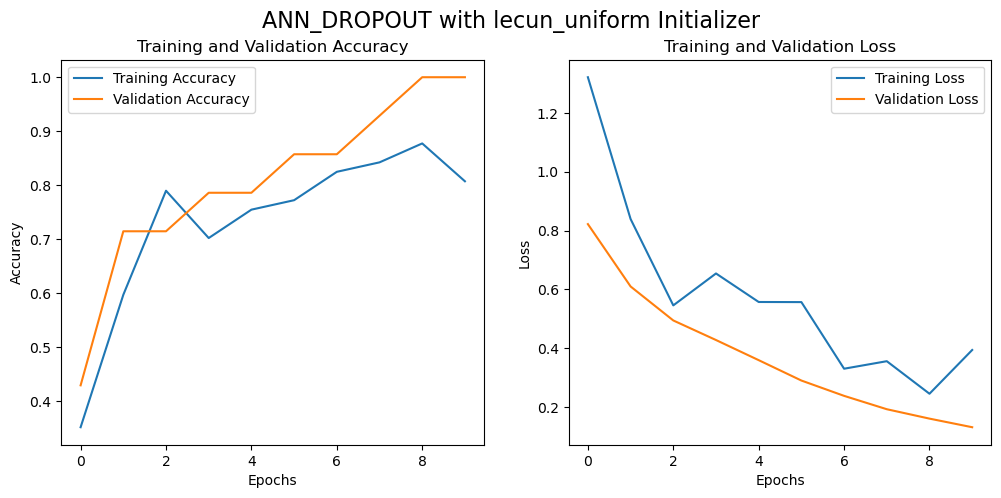

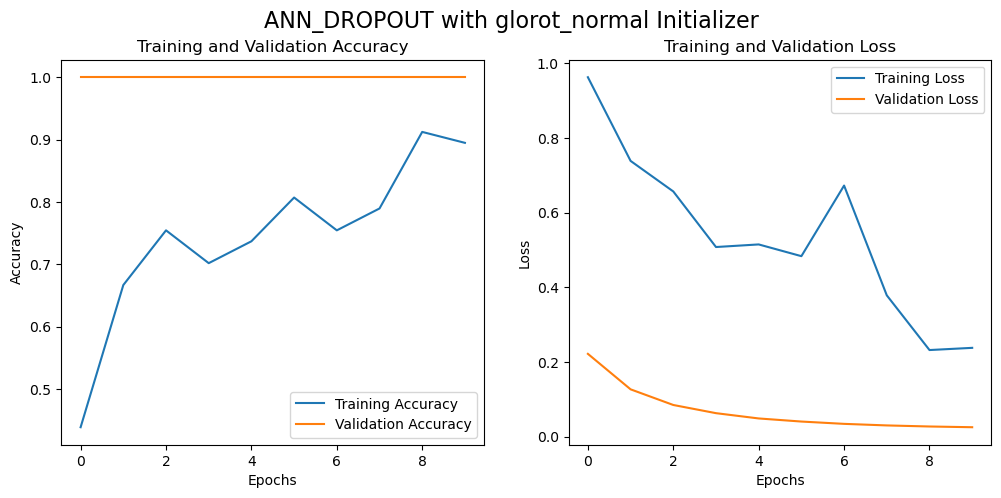

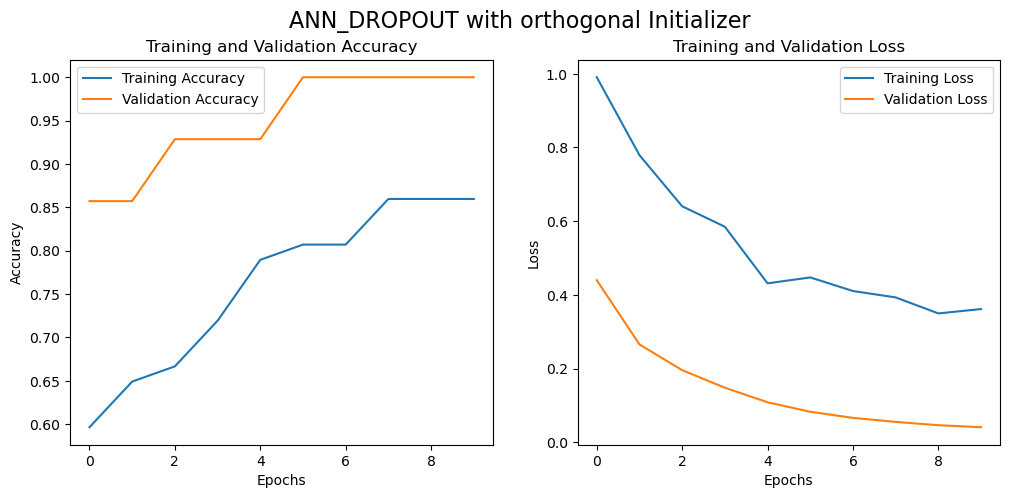

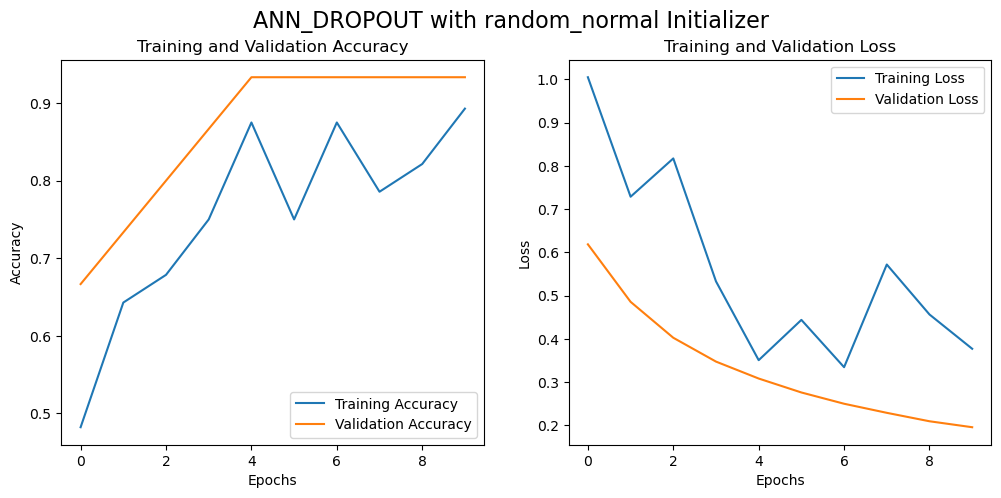

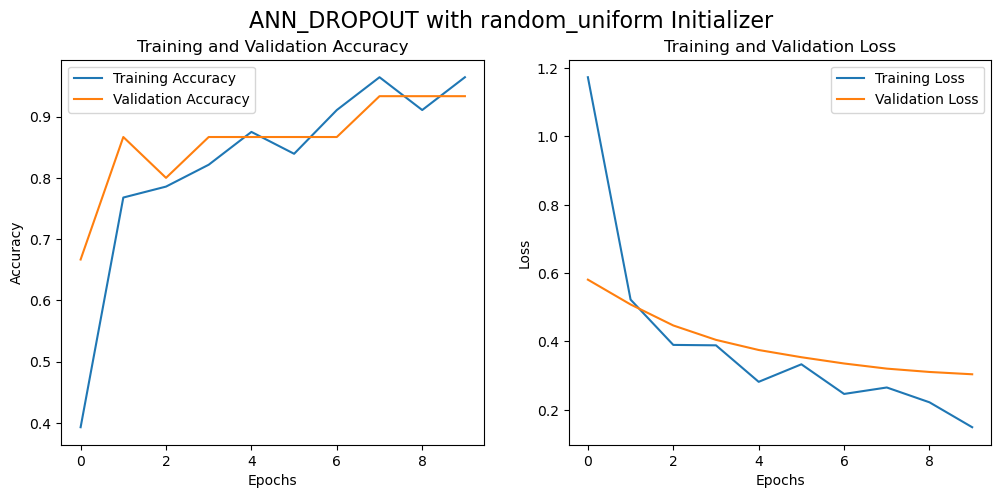

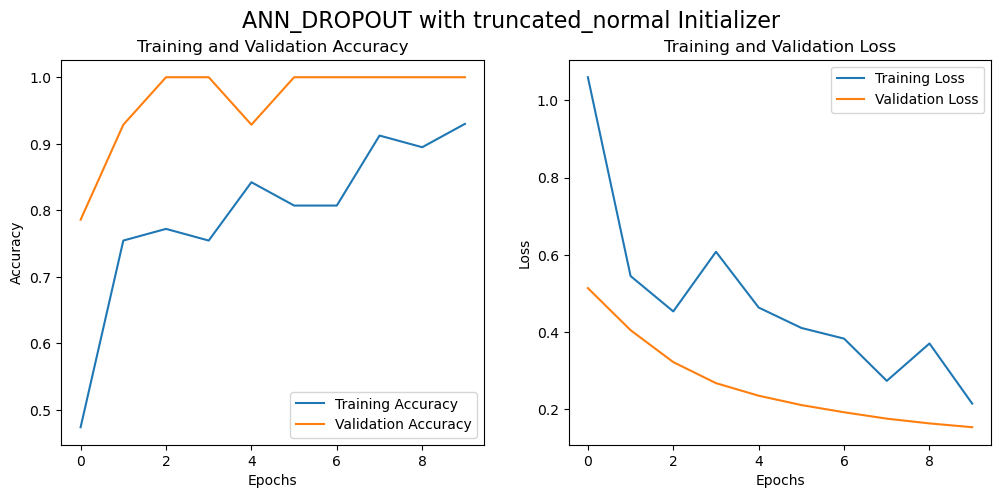

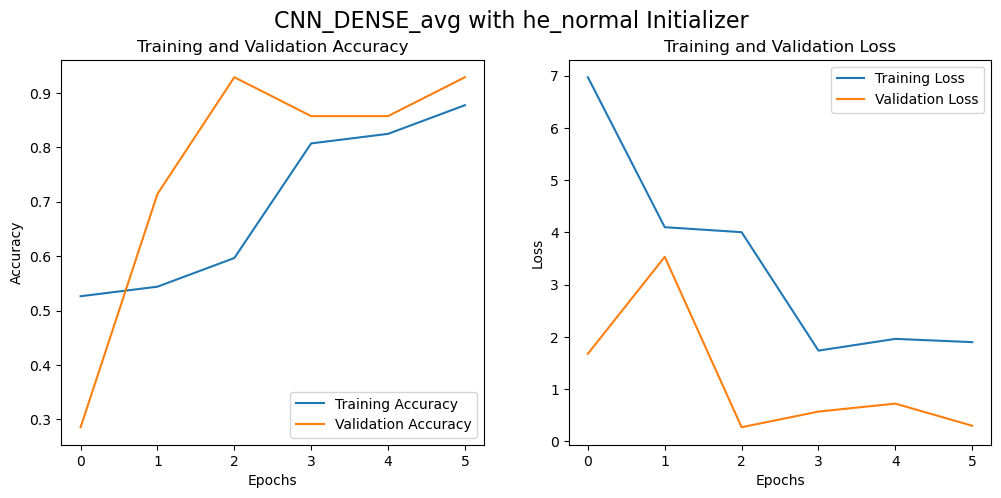

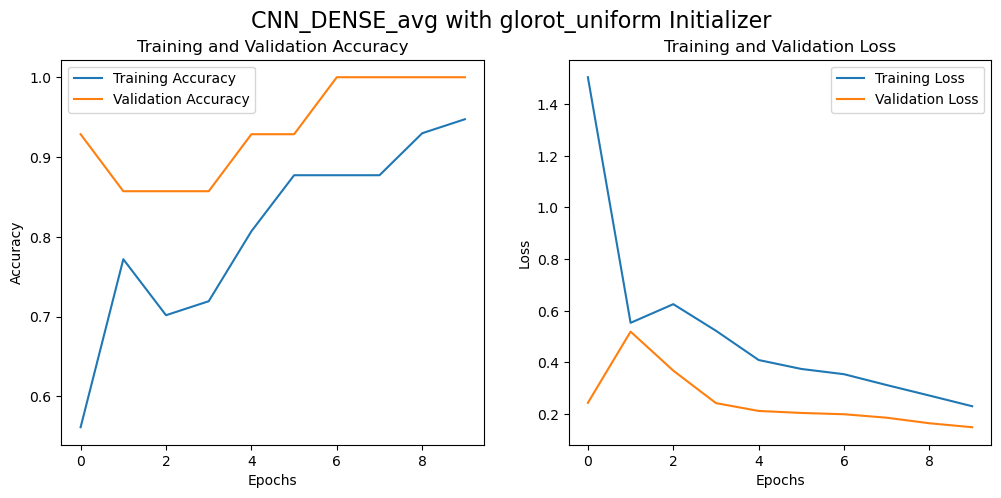

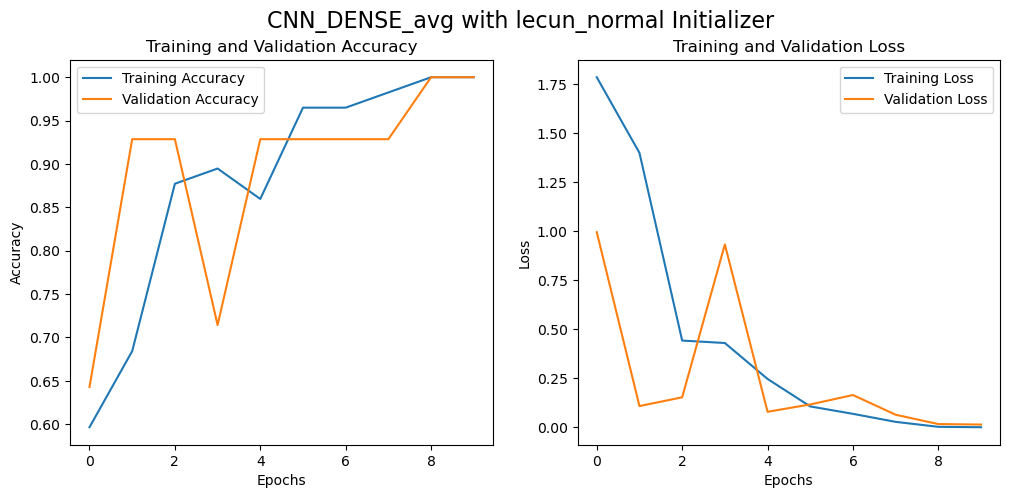

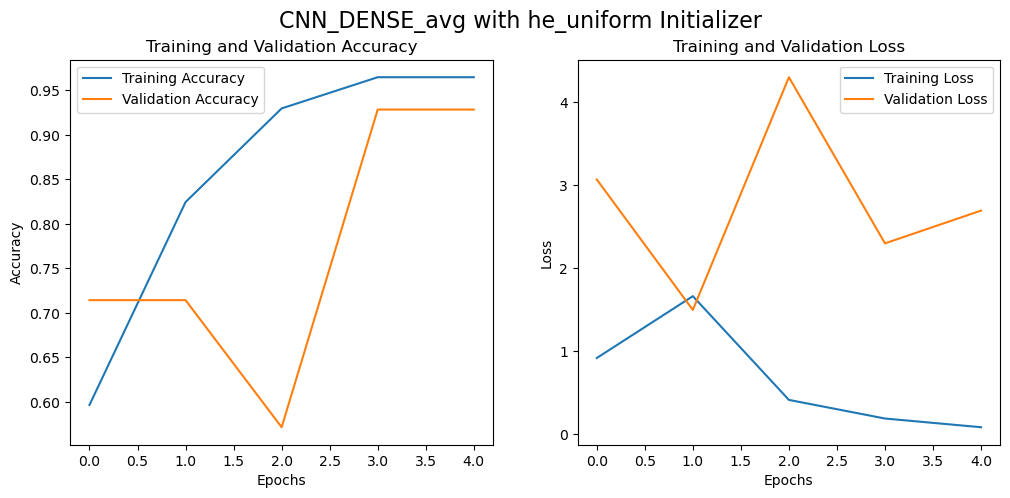

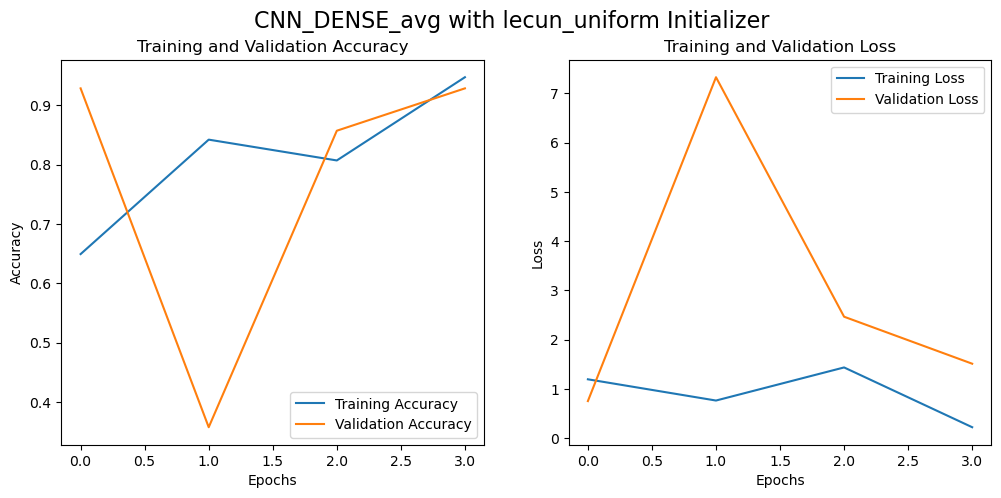

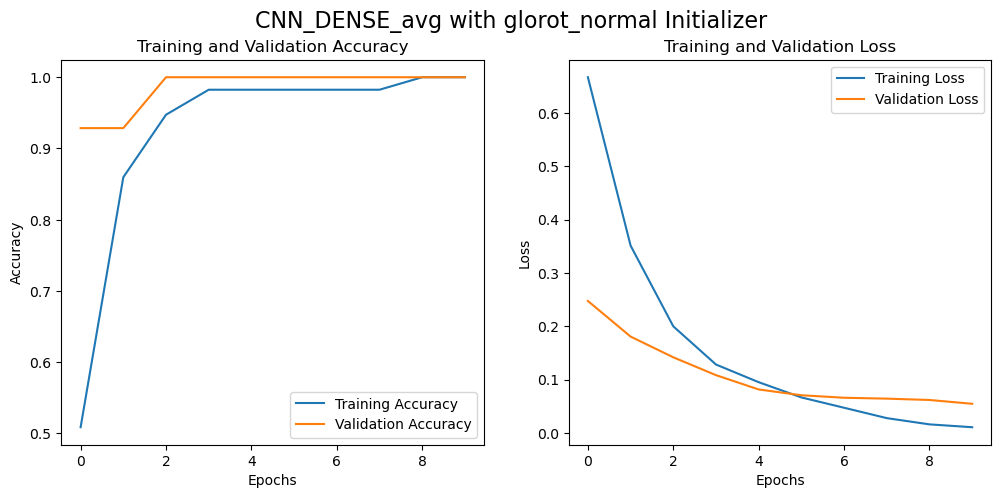

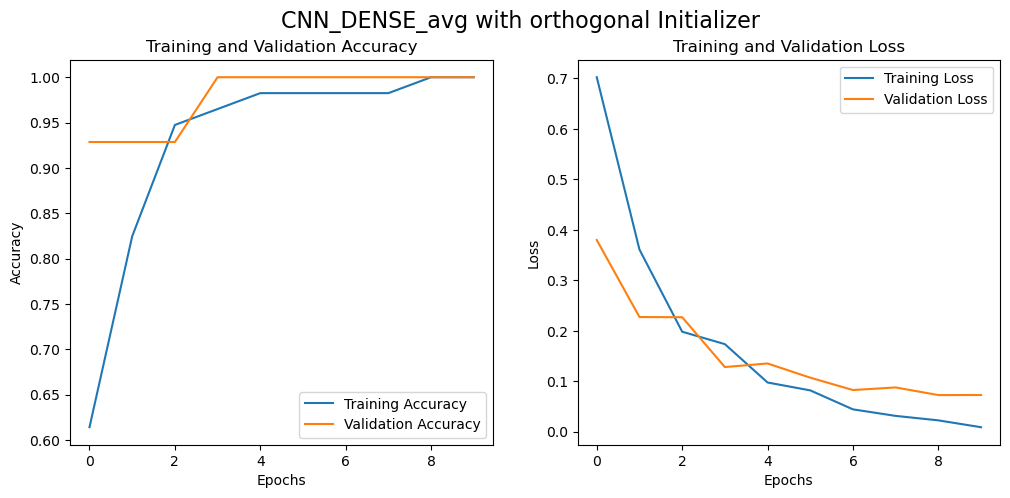

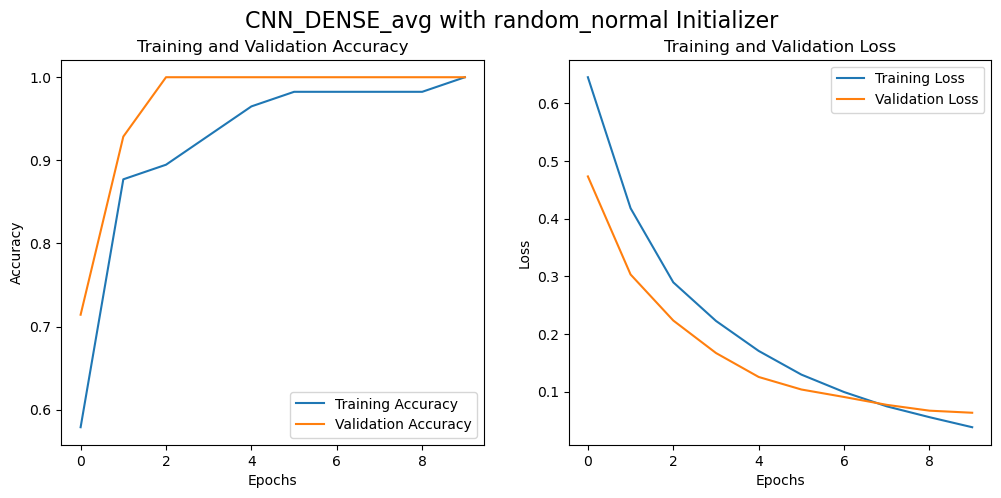

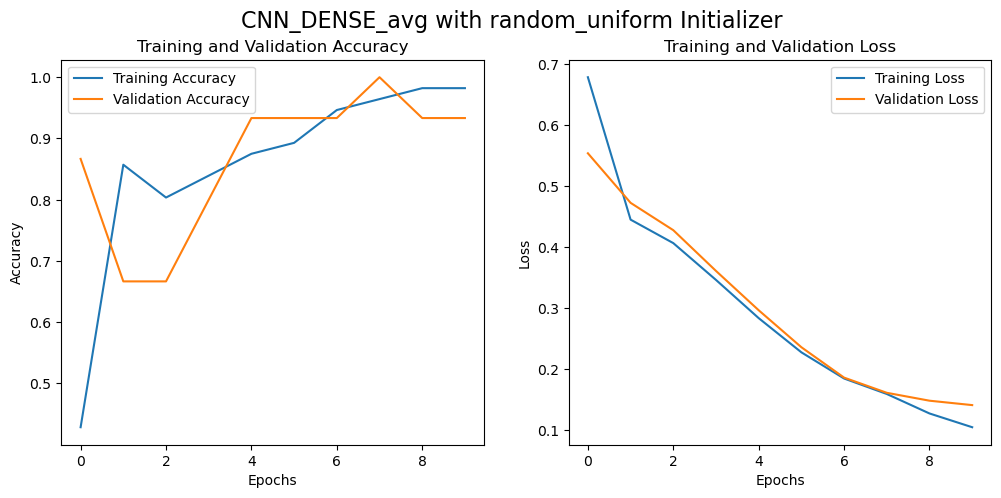

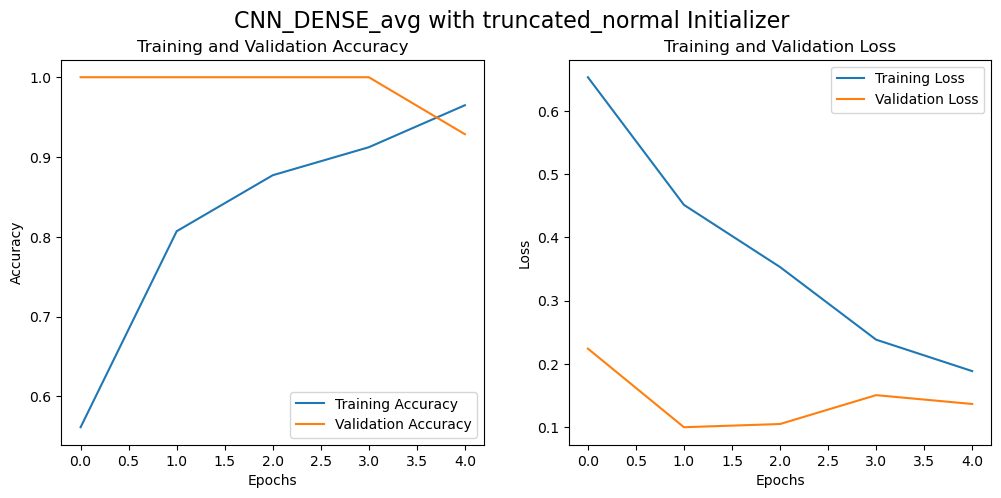

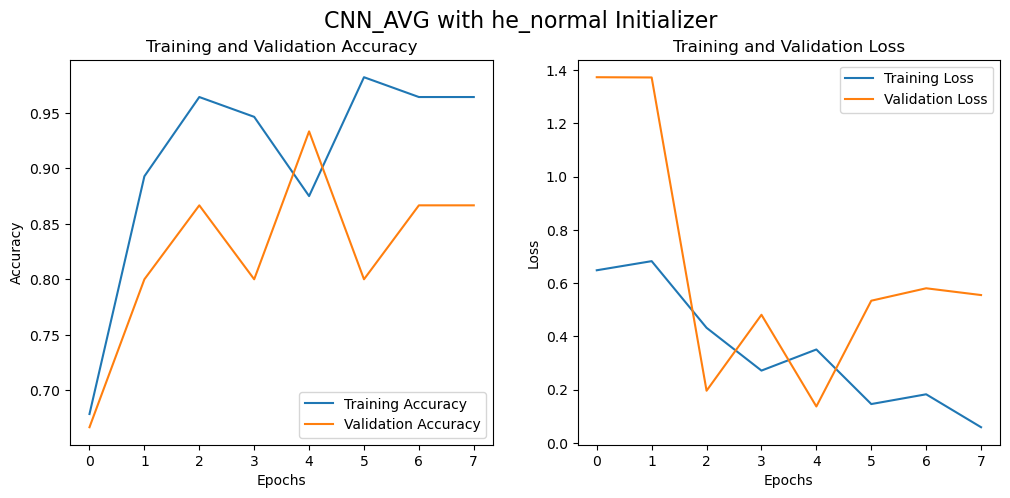

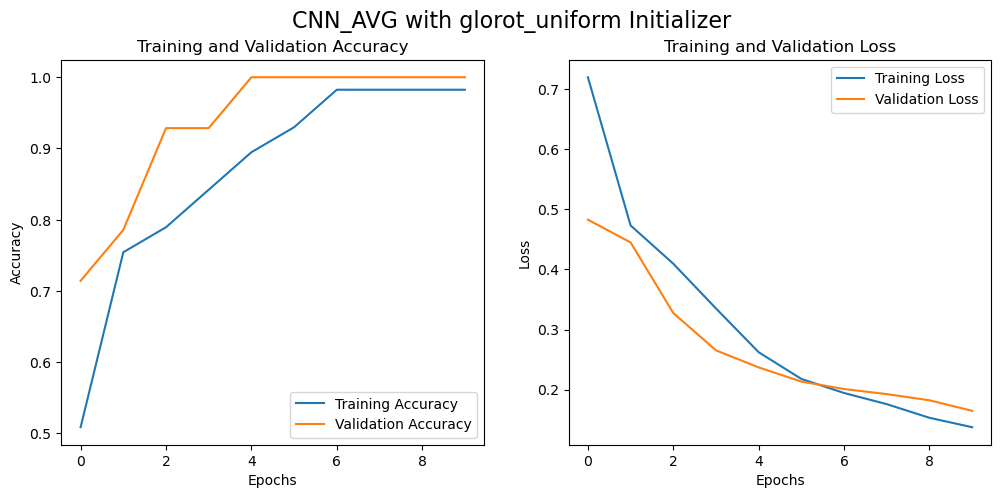

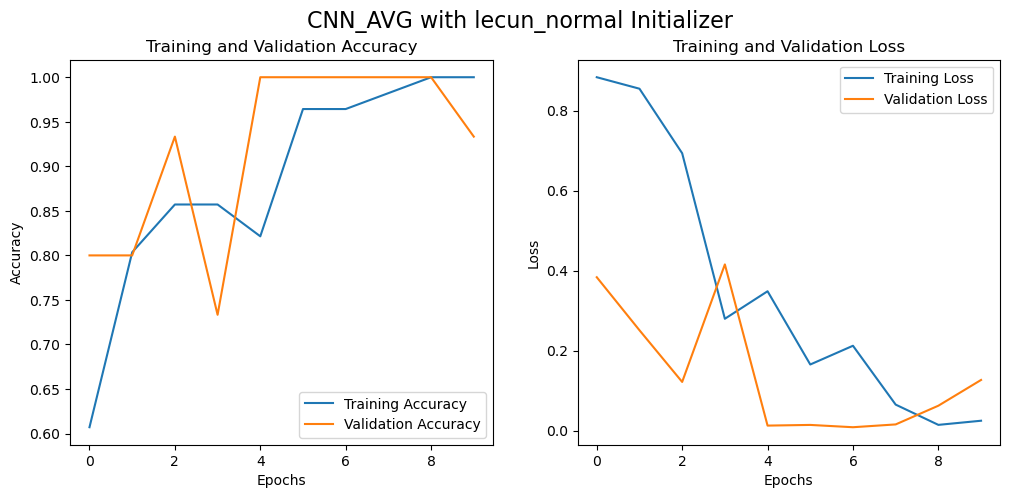

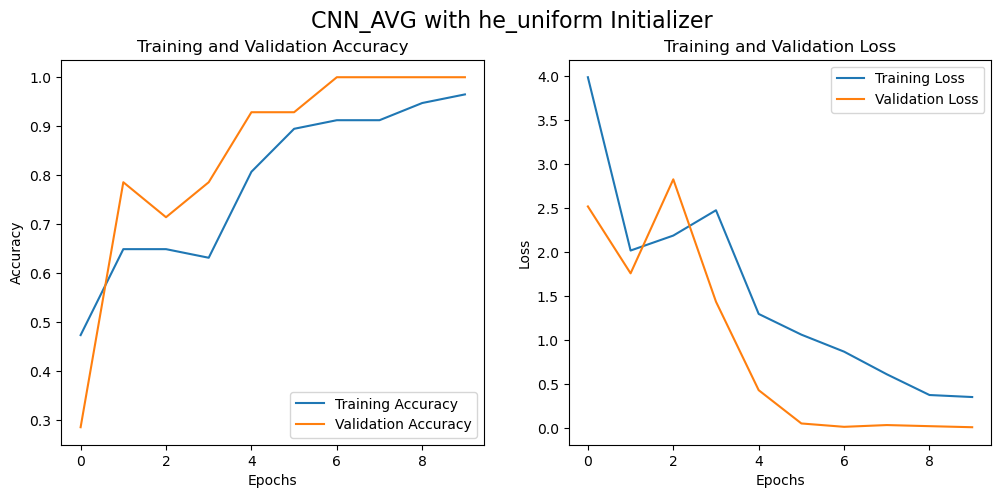

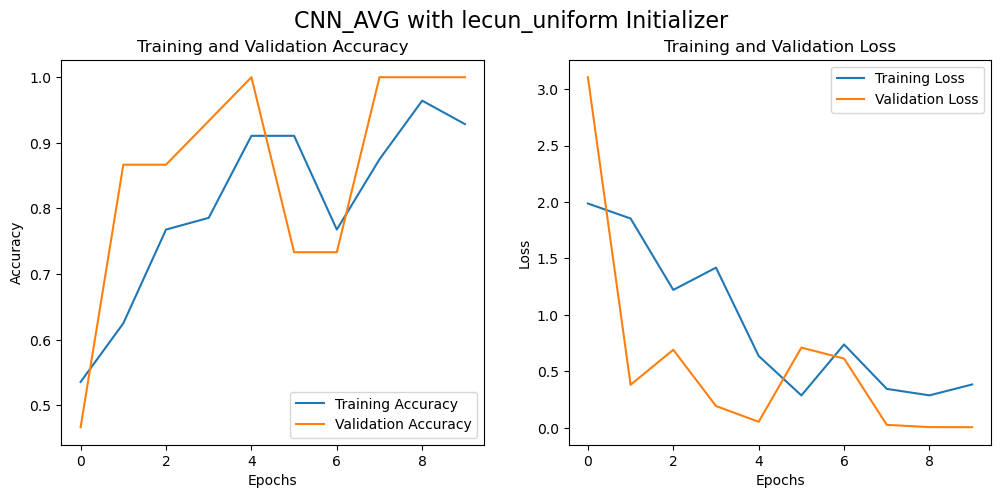

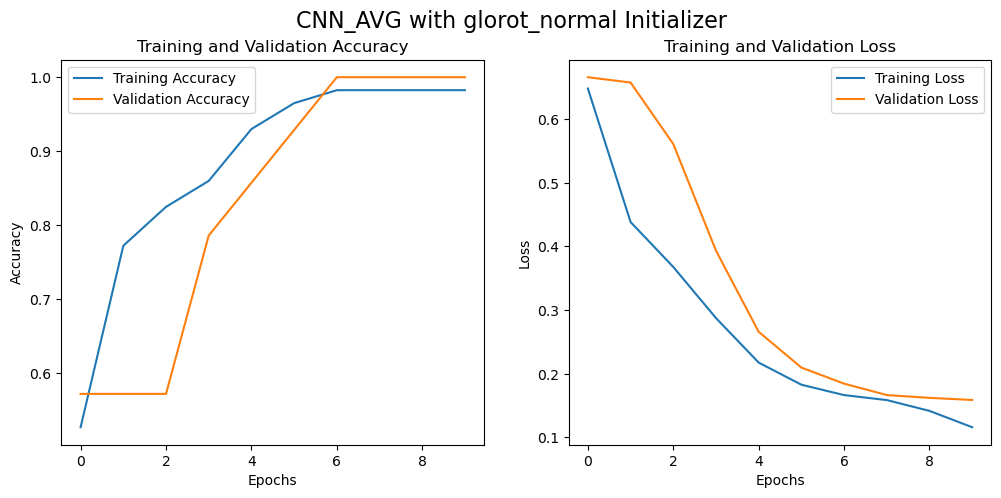

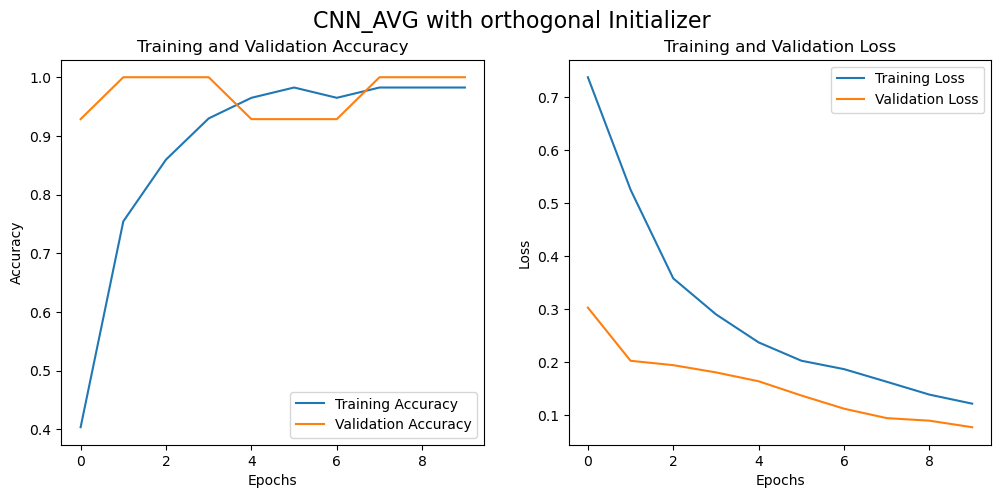

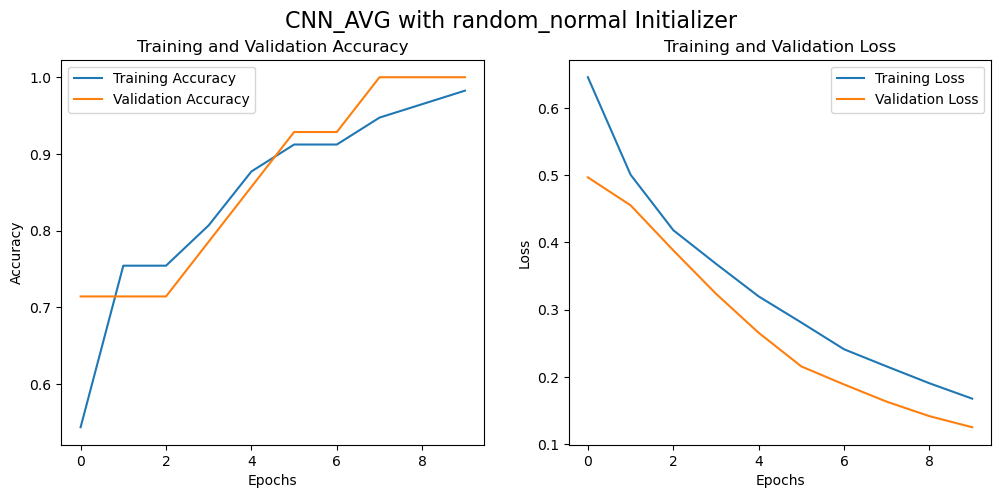

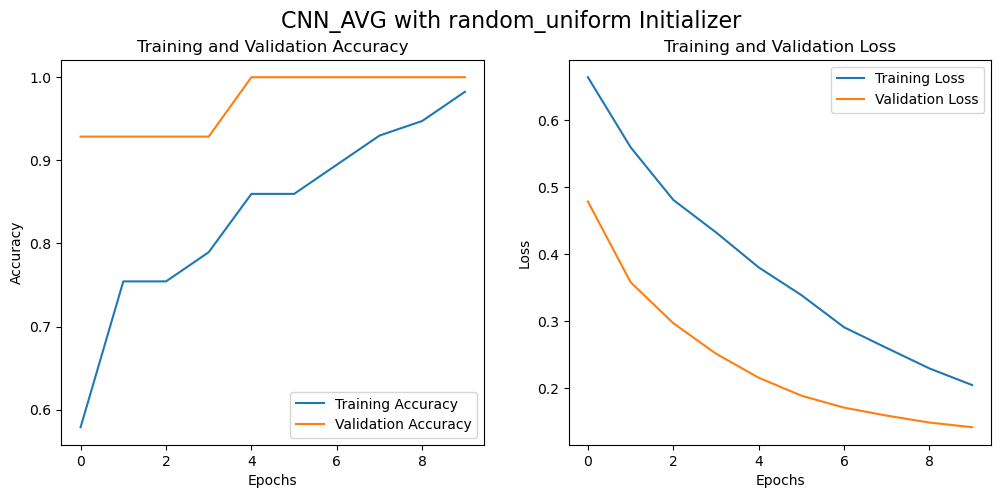

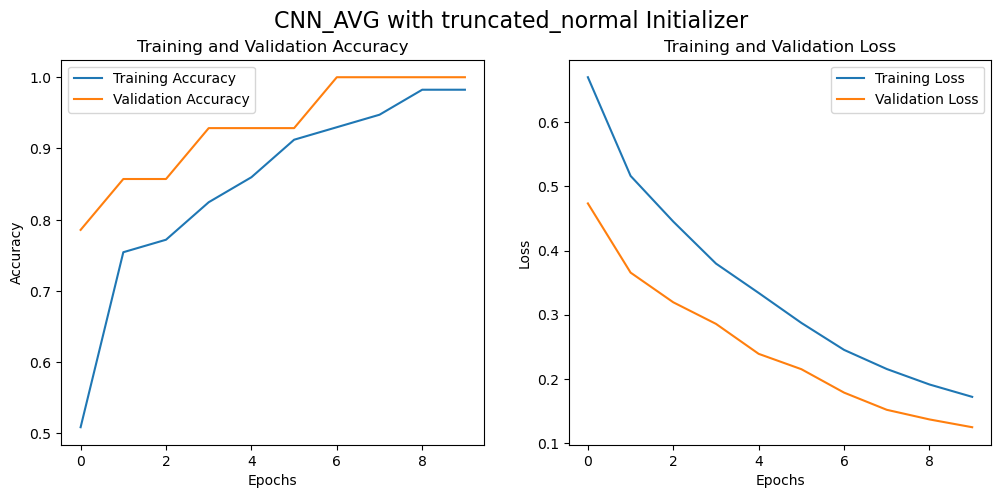

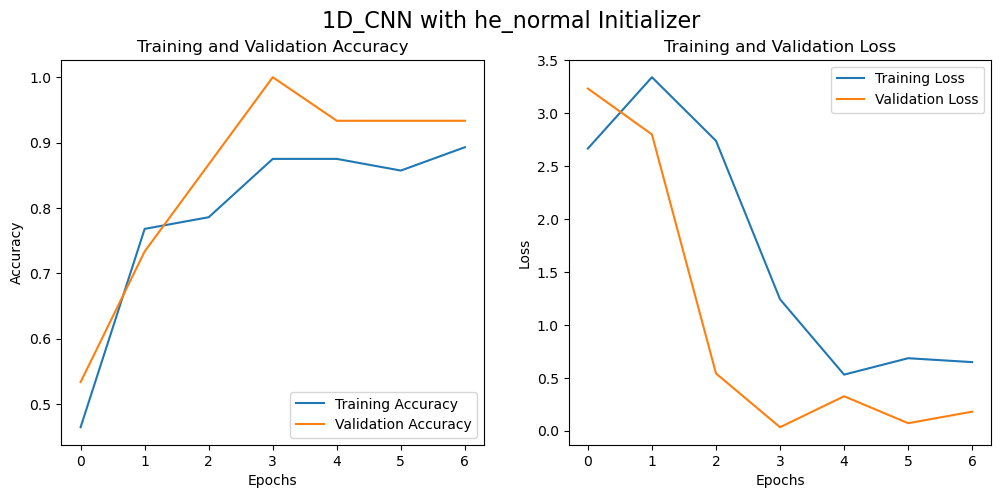

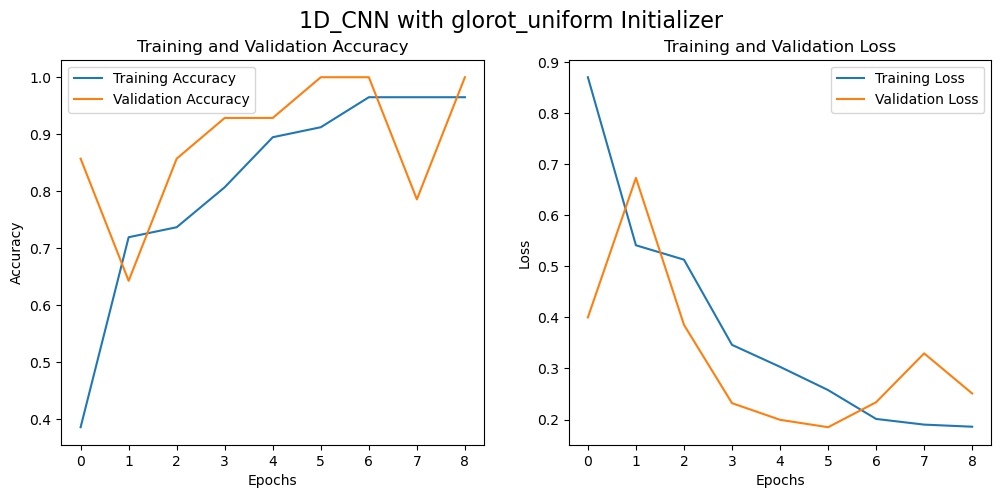

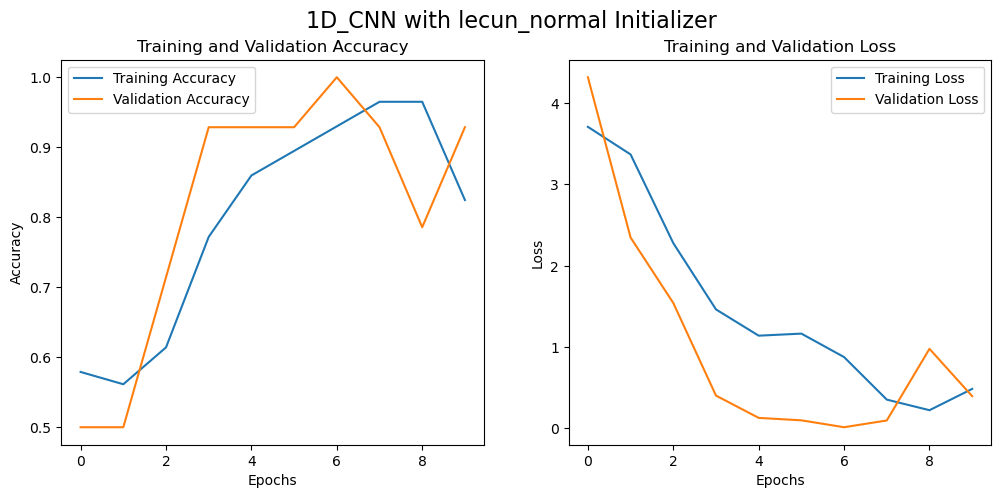

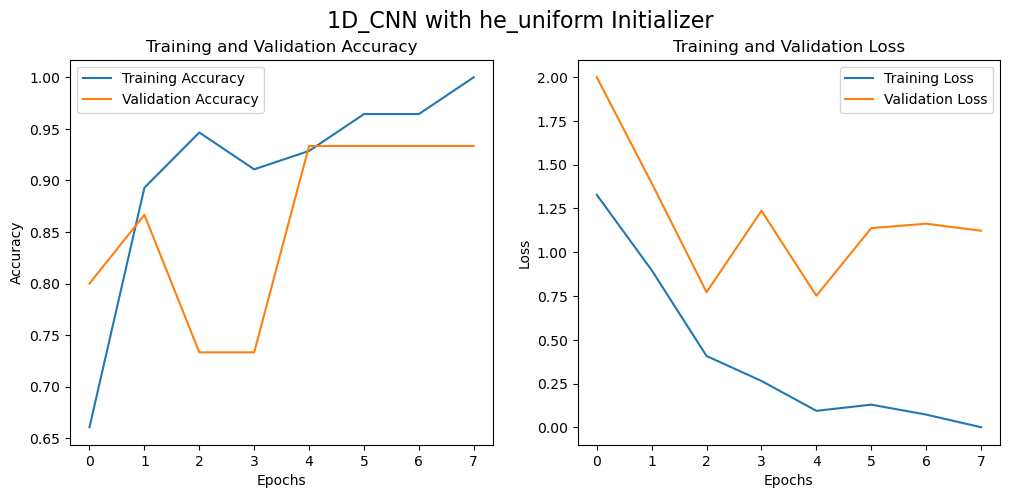

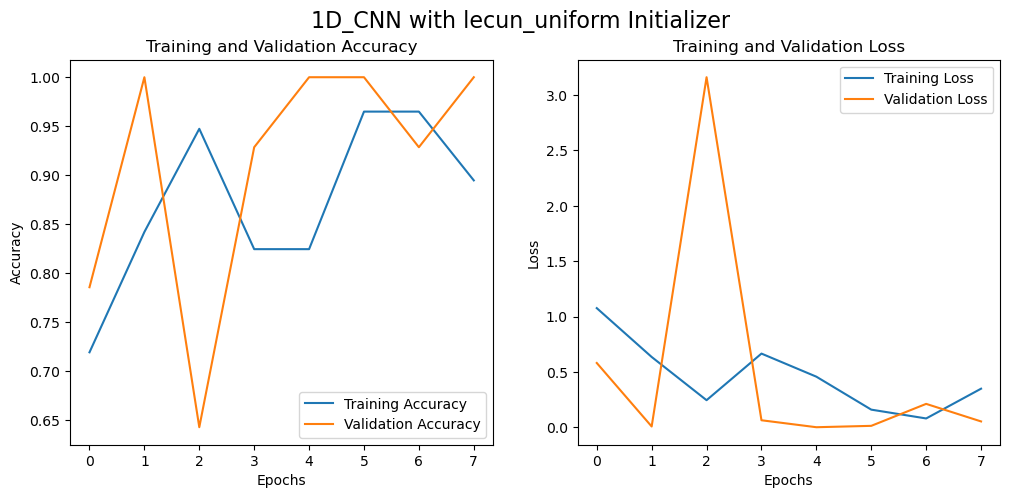

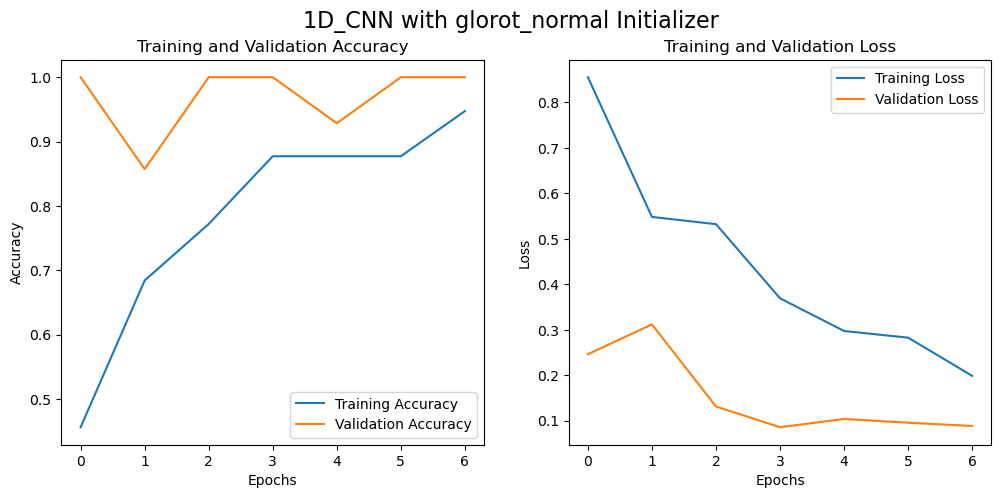

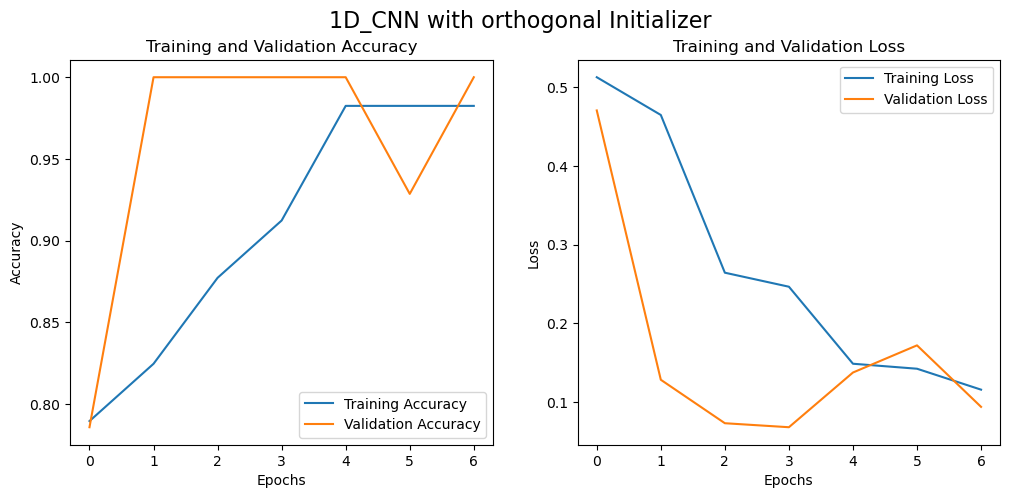

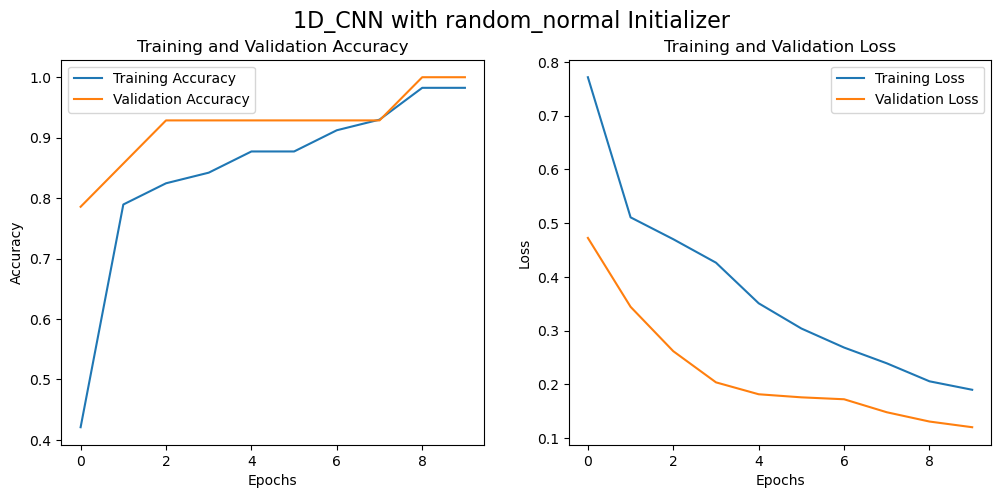

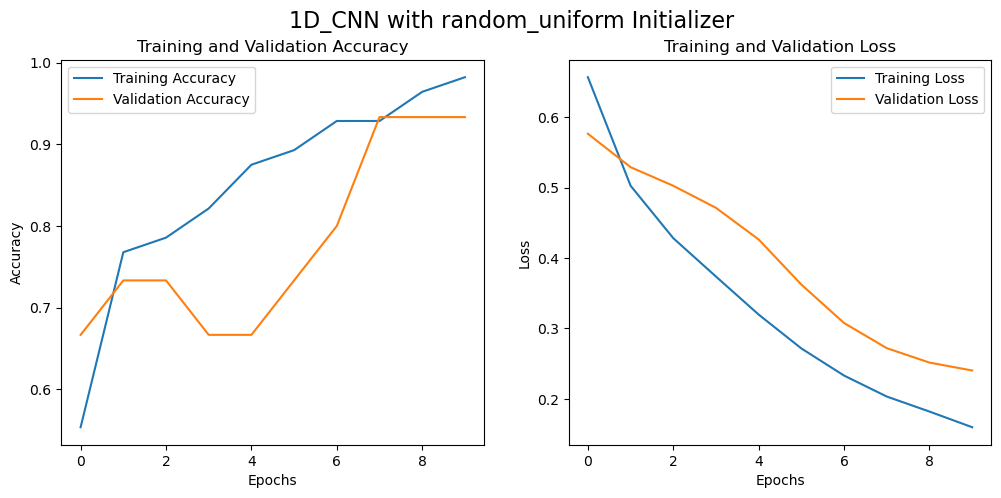

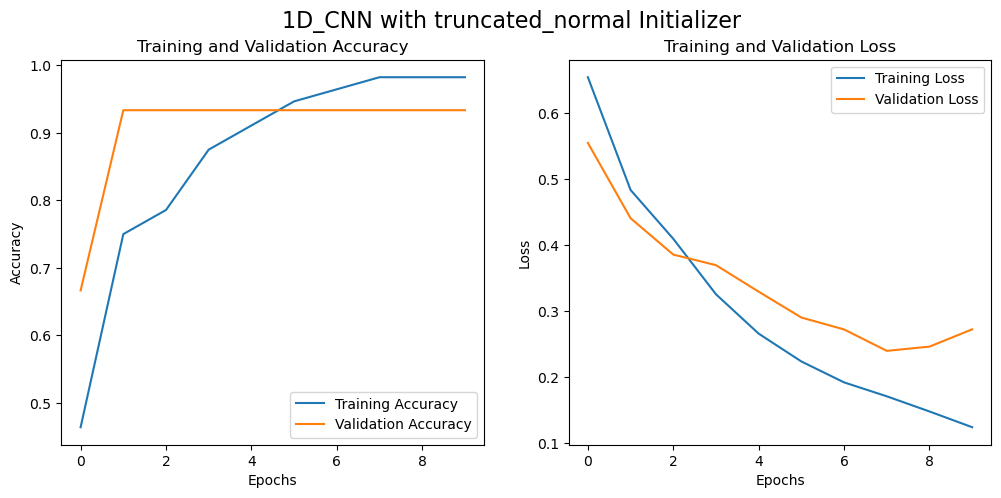

In [2]:
# Plotting the accuracy and loss for each architecture-initializer combination
for architecture in architectures:
    for initializer in initializers:
        history = best_histories[architecture][initializer]

        if history is not None:  # If we have a valid history for this combination
            plt.figure(figsize=(12, 5))
            plt.suptitle(f'{architecture} with {initializer} Initializer', fontsize=16)

            # Accuracy plot
            plt.subplot(1, 2, 1)
            plt.plot(history.history['accuracy'], label='Training Accuracy')
            plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
            plt.title('Training and Validation Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()

            # Loss plot
            plt.subplot(1, 2, 2)
            plt.plot(history.history['loss'], label='Training Loss')
            plt.plot(history.history['val_loss'], label='Validation Loss')
            plt.title('Training and Validation Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()

            plt.show()

In [3]:
# STEP 5: Calculate class probabilities for each saved model
print("\nClass Probabilities for Each Architecture and Initializer:")
for architecture, initializers_dict in best_models.items():
    print(f"\n{architecture} Class Probabilities:")
    for initializer, model in initializers_dict.items():
        test_probs = model.predict(X_test4.values[..., np.newaxis] if '1D_CNN' in architecture else X_test4, verbose=1)
        print(f"\nInitializer: {initializer}")
        print(pd.DataFrame(test_probs.round(4), columns=[f'Class {i+1}' for i in range(output_size)]))




Class Probabilities for Each Architecture and Initializer:

CNN_DENSE_MAX Class Probabilities:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step

Initializer: he_normal
    Class 1  Class 2
0    1.0000   0.0000
1    1.0000   0.0000
2    0.0000   1.0000
3    0.8319   0.1681
4    0.9885   0.0115
5    0.9997   0.0003
6    0.0000   1.0000
7    0.0002   0.9998
8    0.9971   0.0029
9    0.9932   0.0068
10   1.0000   0.0000
11   0.0000   1.0000
12   0.0000   1.0000
13   0.0000   1.0000
14   0.0000   1.0000
15   1.0000   0.0000
16   0.7862   0.2138
17   1.0000   0.0000
18   0.9999   0.0001
19   0.9992   0.0008
20   0.0000   1.0000
21   0.4582   0.5418
22   0.9982   0.0018
23   0.0102   0.9898
24   0.0858   0.9142
25   0.0000   1.0000
26   1.0000   0.0000
27   0.0000   1.0000
28   1.0000   0.0000
29   1.0000   0.0000
30   0.0000   1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step

Initializer: glorot_uniform
    Class 1  Class 2
0    0.9121   0.0879
1    0.9503   0.0497
2    0.0745   0.9255
3    0.7129   0.2

In [4]:
import pandas as pd
import numpy as np

# Initialize a dictionary to store probabilities for each architecture and initializer
architecture_probs = {}

# Initialize a dictionary to store min and max probabilities for each architecture
min_max_probs = {}

# Iterate over architectures and their initializers
for architecture, initializers_dict in best_models.items():
    architecture_probs[architecture] = {}
    
    for initializer, model in initializers_dict.items():
        # Predict class probabilities for the test data
        test_probs = model.predict(X_test4.values[..., np.newaxis] if architecture == '1D_CNN' else X_test4, verbose=0)
        
        # Store probabilities for each initializer
        architecture_probs[architecture][initializer] = test_probs

# Calculate min and max probabilities across initializers for each architecture
print("\nClass Probabilities (Min and Max across Initializers) for Each Architecture:")
for architecture, initializers_dict in architecture_probs.items():
    print(f"\nArchitecture: {architecture}")
    
    # Stack all probabilities for the initializers in this architecture for easier min-max calculation
    all_probs = np.stack(list(initializers_dict.values()), axis=2)  # Shape: (num_samples, num_classes, num_initializers)
    
    # Calculate min and max probabilities across initializers for each class and each sample
    min_probs = np.min(all_probs, axis=2)
    max_probs = np.max(all_probs, axis=2)

    # Store min and max probabilities for this architecture
    min_max_probs[architecture] = (min_probs, max_probs)
    
    # Print min and max probabilities in the required format
    for i, (min_prob, max_prob) in enumerate(zip(min_probs, max_probs)):
        print(f"Sample {i+1}:")
        for class_index in range(min_prob.shape[0]):
            print(f"  Class {class_index + 1}: (Min: {min_prob[class_index]:.4f}, Max: {max_prob[class_index]:.4f})", end=' | ')
        print()  # Newline after each sample



Class Probabilities (Min and Max across Initializers) for Each Architecture:

Architecture: CNN_DENSE_MAX
Sample 1:
  Class 1: (Min: 0.8119, Max: 1.0000) |   Class 2: (Min: 0.0000, Max: 0.1881) | 
Sample 2:
  Class 1: (Min: 0.2242, Max: 1.0000) |   Class 2: (Min: 0.0000, Max: 0.7758) | 
Sample 3:
  Class 1: (Min: 0.0000, Max: 0.0745) |   Class 2: (Min: 0.9255, Max: 1.0000) | 
Sample 4:
  Class 1: (Min: 0.4829, Max: 0.9986) |   Class 2: (Min: 0.0014, Max: 0.5171) | 
Sample 5:
  Class 1: (Min: 0.5705, Max: 0.9999) |   Class 2: (Min: 0.0001, Max: 0.4295) | 
Sample 6:
  Class 1: (Min: 0.7640, Max: 1.0000) |   Class 2: (Min: 0.0000, Max: 0.2360) | 
Sample 7:
  Class 1: (Min: 0.0000, Max: 0.0221) |   Class 2: (Min: 0.9779, Max: 1.0000) | 
Sample 8:
  Class 1: (Min: 0.0002, Max: 0.9987) |   Class 2: (Min: 0.0013, Max: 0.9998) | 
Sample 9:
  Class 1: (Min: 0.2908, Max: 0.9971) |   Class 2: (Min: 0.0029, Max: 0.7092) | 
Sample 10:
  Class 1: (Min: 0.4591, Max: 0.9966) |   Class 2: (Min: 0.0034

In [5]:
import numpy as np

num_architectures = len(min_max_probs)
"""mean_min_probs = np.ones_like(next(iter(min_max_probs.values()))[0])  # Initialize with ones for geometric mean
mean_max_probs = np.zeros_like(next(iter(min_max_probs.values()))[1])  # Initialize with zeros for arithmetic mean

for min_probs, max_probs in min_max_probs.values():
    mean_min_probs *= min_probs  # Multiply for geometric mean
    mean_max_probs += max_probs  # Add for arithmetic mean

# Calculate geometric mean for min_probs
mean_min_probs = mean_min_probs ** (1 / num_architectures)

# Divide by the number of architectures for arithmetic mean
mean_max_probs /= num_architectures"""

mean_min_probs_log = np.zeros_like(next(iter(min_max_probs.values()))[0])  # Initialize with zeros for log-sum
mean_max_probs = np.zeros_like(next(iter(min_max_probs.values()))[1])  # Initialize with zeros for arithmetic mean

for min_probs, max_probs in min_max_probs.values():
    mean_min_probs_log += np.log(min_probs)  # Add log of min_probs for geometric mean
    mean_max_probs += max_probs  # Add for arithmetic mean

# Calculate geometric mean for min_probs using logs
mean_min_probs = np.exp(mean_min_probs_log / num_architectures)

# Divide by the number of architectures for arithmetic mean
mean_max_probs /= num_architectures

# Print the results in the specified format
print("\nArithmetic Mean of Max Probabilities and Geometric Mean of Min Probabilities Across All Architectures:")
for i, (mean_min, mean_max) in enumerate(zip(mean_min_probs, mean_max_probs)):
    print(f"Sample {i+1}:")
    for class_index in range(mean_min.shape[0]):
        print(f"  Class {class_index + 1}: (Geometric Mean Min: {mean_min[class_index]:.4f}, Arithmetic Mean Max: {mean_max[class_index]:.4f})", end=' | ')
    print()  # Newline after each sample



Arithmetic Mean of Max Probabilities and Geometric Mean of Min Probabilities Across All Architectures:
Sample 1:
  Class 1: (Geometric Mean Min: 0.8277, Arithmetic Mean Max: 0.9993) |   Class 2: (Geometric Mean Min: 0.0000, Arithmetic Mean Max: 0.1617) | 
Sample 2:
  Class 1: (Geometric Mean Min: 0.1101, Arithmetic Mean Max: 0.9999) |   Class 2: (Geometric Mean Min: 0.0000, Arithmetic Mean Max: 0.5651) | 
Sample 3:
  Class 1: (Geometric Mean Min: 0.0000, Arithmetic Mean Max: 0.0860) |   Class 2: (Geometric Mean Min: 0.9135, Arithmetic Mean Max: 1.0000) | 
Sample 4:
  Class 1: (Geometric Mean Min: 0.2268, Arithmetic Mean Max: 0.9705) |   Class 2: (Geometric Mean Min: 0.0006, Arithmetic Mean Max: 0.5710) | 
Sample 5:
  Class 1: (Geometric Mean Min: 0.4750, Arithmetic Mean Max: 0.9980) |   Class 2: (Geometric Mean Min: 0.0000, Arithmetic Mean Max: 0.4312) | 
Sample 6:
  Class 1: (Geometric Mean Min: 0.8258, Arithmetic Mean Max: 0.9998) |   Class 2: (Geometric Mean Min: 0.0000, Arithmetic

In [6]:
"""# Calculate the arithmetic mean of min and max values across architectures for each sample
num_architectures = len(min_max_probs)
mean_min_probs = np.zeros_like(next(iter(min_max_probs.values()))[0])
mean_max_probs = np.zeros_like(next(iter(min_max_probs.values()))[1])

for min_probs, max_probs in min_max_probs.values():
    mean_min_probs += min_probs
    mean_max_probs += max_probs

# Divide by the number of architectures to get the mean
mean_min_probs /= num_architectures
mean_max_probs /= num_architectures

# Print the results in the specified format
print("\nArithmetic Mean of Min and Max Probabilities Across All Architectures:")
for i, (mean_min, mean_max) in enumerate(zip(mean_min_probs, mean_max_probs)):
    print(f"Sample {i+1}:")
    for class_index in range(mean_min.shape[0]):
        print(f"  Class {class_index + 1}: (Mean Min: {mean_min[class_index]:.4f}, Mean Max: {mean_max[class_index]:.4f})", end=' | ')
    print()  # Newline after each sample"""

'# Calculate the arithmetic mean of min and max values across architectures for each sample\nnum_architectures = len(min_max_probs)\nmean_min_probs = np.zeros_like(next(iter(min_max_probs.values()))[0])\nmean_max_probs = np.zeros_like(next(iter(min_max_probs.values()))[1])\n\nfor min_probs, max_probs in min_max_probs.values():\n    mean_min_probs += min_probs\n    mean_max_probs += max_probs\n\n# Divide by the number of architectures to get the mean\nmean_min_probs /= num_architectures\nmean_max_probs /= num_architectures\n\n# Print the results in the specified format\nprint("\nArithmetic Mean of Min and Max Probabilities Across All Architectures:")\nfor i, (mean_min, mean_max) in enumerate(zip(mean_min_probs, mean_max_probs)):\n    print(f"Sample {i+1}:")\n    for class_index in range(mean_min.shape[0]):\n        print(f"  Class {class_index + 1}: (Mean Min: {mean_min[class_index]:.4f}, Mean Max: {mean_max[class_index]:.4f})", end=\' | \')\n    print()  # Newline after each sample'

In [7]:
"""import numpy as np

# Initialize a dictionary to store min and max probabilities for each architecture
min_max_probs = {}

# Iterate over architectures to calculate min and max probabilities for each class
for architecture, initializers_dict in architecture_probs.items():
    # Stack all probabilities for the initializers in this architecture
    all_probs = np.stack(list(initializers_dict.values()), axis=2)  # Shape: (num_samples, num_classes, num_initializers)
    
    # Calculate min and max probabilities across initializers for each class and each sample
    min_probs = np.min(all_probs, axis=2)
    max_probs = np.max(all_probs, axis=2)
    
    # Store min and max probabilities for this architecture
    min_max_probs[architecture] = (min_probs, max_probs)

# Calculate the minimum of the min values and the maximum of the max values across architectures
all_min_values = np.array([min_probs for min_probs, _ in min_max_probs.values()])  # Shape: (num_architectures, num_samples, num_classes)
all_max_values = np.array([max_probs for _, max_probs in min_max_probs.values()])  # Shape: (num_architectures, num_samples, num_classes)

# Find the min of min values and max of max values for each sample and class
min_of_mins = np.min(all_min_values, axis=0)
max_of_maxes = np.max(all_max_values, axis=0)

# Print the results in the specified format
print("\nMin of Min Values and Max of Max Values Across All Architectures:")
for i, (min_vals, max_vals) in enumerate(zip(min_of_mins, max_of_maxes)):
    print(f"Sample {i+1}:")
    for class_index in range(min_vals.shape[0]):
        print(f"  Class {class_index + 1}: (Min of Min: {min_vals[class_index]:.4f}, Max of Max: {max_vals[class_index]:.4f})", end=' | ')
    print()  # Newline after each sample"""


'import numpy as np\n\n# Initialize a dictionary to store min and max probabilities for each architecture\nmin_max_probs = {}\n\n# Iterate over architectures to calculate min and max probabilities for each class\nfor architecture, initializers_dict in architecture_probs.items():\n    # Stack all probabilities for the initializers in this architecture\n    all_probs = np.stack(list(initializers_dict.values()), axis=2)  # Shape: (num_samples, num_classes, num_initializers)\n    \n    # Calculate min and max probabilities across initializers for each class and each sample\n    min_probs = np.min(all_probs, axis=2)\n    max_probs = np.max(all_probs, axis=2)\n    \n    # Store min and max probabilities for this architecture\n    min_max_probs[architecture] = (min_probs, max_probs)\n\n# Calculate the minimum of the min values and the maximum of the max values across architectures\nall_min_values = np.array([min_probs for min_probs, _ in min_max_probs.values()])  # Shape: (num_architectures, 

In [8]:
"""w = 0.1
gama=0.1
P = 4

# Calculate the combined values
#combined_values = w * ((geometric_mean_F_values + arithmetic_mean_G_values) / 2) + (1 - w) * (1 - (arithmetic_mean_G_values - geometric_mean_F_values))**P
combined_values = w * (((1 - gama)*min_of_mins + gama*max_of_maxes)) + (1 - w) * (1 - (max_of_maxes - min_of_mins))**P
# Print geometric mean F and average G values along with the combined values for each sample
for sample_idx in range(X_test4.shape[0]):
    print(f"\nGeometric Mean, Average, and Combined for Test Sample {sample_idx + 1}:")
    for class_idx in range(output_size):
        geom_F = min_of_mins[sample_idx, class_idx]
        avg_G = max_of_maxes[sample_idx, class_idx]
        combined_value = combined_values[sample_idx, class_idx]
        print(f"Class {class_idx + 1}: [F, G] = [{geom_F:.4f}, {avg_G:.4f}], Combined = {combined_value:.4f}")"""

'w = 0.1\ngama=0.1\nP = 4\n\n# Calculate the combined values\n#combined_values = w * ((geometric_mean_F_values + arithmetic_mean_G_values) / 2) + (1 - w) * (1 - (arithmetic_mean_G_values - geometric_mean_F_values))**P\ncombined_values = w * (((1 - gama)*min_of_mins + gama*max_of_maxes)) + (1 - w) * (1 - (max_of_maxes - min_of_mins))**P\n# Print geometric mean F and average G values along with the combined values for each sample\nfor sample_idx in range(X_test4.shape[0]):\n    print(f"\nGeometric Mean, Average, and Combined for Test Sample {sample_idx + 1}:")\n    for class_idx in range(output_size):\n        geom_F = min_of_mins[sample_idx, class_idx]\n        avg_G = max_of_maxes[sample_idx, class_idx]\n        combined_value = combined_values[sample_idx, class_idx]\n        print(f"Class {class_idx + 1}: [F, G] = [{geom_F:.4f}, {avg_G:.4f}], Combined = {combined_value:.4f}")'

In [9]:
"""# Parameters for the formula
w = 0.3
gama = 0.7
P = 2

# Calculate the combined values
#combined_values = w * ((geometric_mean_F_values + arithmetic_mean_G_values) / 2) + (1 - w) * (1 - (arithmetic_mean_G_values - geometric_mean_F_values))**P
combined_values = w * (((1 - gama)*mean_min_probs + gama*mean_max_probs)) + (1 - w) * (1 - (mean_max_probs - mean_min_probs))**P
# Print geometric mean F and average G values along with the combined values for each sample
for sample_idx in range(X_test4.shape[0]):
    print(f"\nGeometric Mean, Arithmetic Mean, and Combined for Test Sample {sample_idx + 1}:")
    for class_idx in range(output_size):
        geom_F = mean_min_probs[sample_idx, class_idx]
        avg_G = mean_max_probs[sample_idx, class_idx]
        combined_value = combined_values[sample_idx, class_idx]
        print(f"Class {class_idx + 1}: [m, M] = [{geom_F:.4f}, {avg_G:.4f}], Combined = {combined_value:.4f}")"""

'# Parameters for the formula\nw = 0.3\ngama = 0.7\nP = 2\n\n# Calculate the combined values\n#combined_values = w * ((geometric_mean_F_values + arithmetic_mean_G_values) / 2) + (1 - w) * (1 - (arithmetic_mean_G_values - geometric_mean_F_values))**P\ncombined_values = w * (((1 - gama)*mean_min_probs + gama*mean_max_probs)) + (1 - w) * (1 - (mean_max_probs - mean_min_probs))**P\n# Print geometric mean F and average G values along with the combined values for each sample\nfor sample_idx in range(X_test4.shape[0]):\n    print(f"\nGeometric Mean, Arithmetic Mean, and Combined for Test Sample {sample_idx + 1}:")\n    for class_idx in range(output_size):\n        geom_F = mean_min_probs[sample_idx, class_idx]\n        avg_G = mean_max_probs[sample_idx, class_idx]\n        combined_value = combined_values[sample_idx, class_idx]\n        print(f"Class {class_idx + 1}: [m, M] = [{geom_F:.4f}, {avg_G:.4f}], Combined = {combined_value:.4f}")'

In [10]:
import numpy as np

# Initial parameters
w = 0.5
gama = 0.8
P = 2

# Sample probabilities (example data, replace with your actual probabilities)
#mean_min_probs = np.array([...])  # Replace with actual `mean_min_probs` array
#mean_max_probs = np.array([...])  # Replace with actual `mean_max_probs` array
output_size = mean_min_probs.shape[1]

# Function to calculate combined values
def calculate_combined(w, gama, P, mean_min_probs, mean_max_probs):
    return w * (((1 - gama) * mean_min_probs + gama * mean_max_probs)) + \
           (1 - w) * (1 - (mean_max_probs - mean_min_probs))**P

# Parameter grid search
best_params = None
best_accuracy = 0

for new_w in np.arange(0.01, 1.0, 0.01):  # Wider range and smaller step for w
    for new_gama in np.arange(0.01, 1.0, 0.01):  # Wider range and smaller step for gama
        for new_P in range(1, 4):
            # Calculate combined values
            #combined_values = calculate_combined(new_w, new_gama, new_P, mean_min_probs, mean_max_probs)
            # Calculate combined values
            combined_values = calculate_combined(new_w, new_gama, new_P, mean_min_probs, mean_max_probs)
            
            # Evaluate classifications
            predicted_classes = np.argmax(combined_values, axis=1)
            true_classes = np.argmax(y_test4, axis=1)
            
            # Compare element-wise
            correct_classifications = np.sum(predicted_classes == true_classes)
            
            # Calculate accuracy
            accuracy = correct_classifications / mean_min_probs.shape[0]
            
            # Evaluate classifications
            #correct_classifications = 0
            #for sample_idx in range(mean_min_probs.shape[0]):
                # Classify based on higher combined value
                #predicted_class = np.argmax(combined_values[sample_idx])
                #predicted_class = np.argmax(combined_values, axis=1)
                #true_class = np.argmax(y_test4, axis=1)
                #true_class = np.argmax(mean_max_probs[sample_idx])  # Replace with true labels if available
                
                #if predicted_class == true_class:
                    #correct_classifications += 1
            
            # Calculate accuracy
            #accuracy = correct_classifications / mean_min_probs.shape[0]
            
            # Update best parameters if accuracy improves
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = (new_w, new_gama, new_P)

# Output best parameters and accuracy
print(f"Best Parameters: w = {best_params[0]}, gama = {best_params[1]}, P = {best_params[2]}")
print(f"Best Accuracy: {best_accuracy:.4f}")


Best Parameters: w = 0.33, gama = 0.16, P = 3
Best Accuracy: 0.9677


In [41]:
# Parameters for the formula
#w = best_params[0]
#gama = best_params[1]
#P = best_params[2]
w = 0.5
gama = 0.5
P = 1

# Calculate the combined values
#combined_values = w * ((geometric_mean_F_values + arithmetic_mean_G_values) / 2) + (1 - w) * (1 - (arithmetic_mean_G_values - geometric_mean_F_values))**P
combined_values = w * (((1 - gama)*mean_min_probs + gama*mean_max_probs)) + (1 - w) * (1 - (mean_max_probs - mean_min_probs))**P
# Print geometric mean F and average G values along with the combined values for each sample
for sample_idx in range(X_test4.shape[0]):
    print(f"\nGeometric Mean, Arithmetic Mean, and Combined for Test Sample {sample_idx + 1}:")
    for class_idx in range(output_size):
        geom_F = mean_min_probs[sample_idx, class_idx]
        avg_G = mean_max_probs[sample_idx, class_idx]
        combined_value = combined_values[sample_idx, class_idx]
        print(f"Class {class_idx + 1}: [m, M] = [{geom_F:.4f}, {avg_G:.4f}], Combined = {combined_value:.4f}")


Geometric Mean, Arithmetic Mean, and Combined for Test Sample 1:
Class 1: [m, M] = [0.8277, 0.9993], Combined = 0.8710
Class 2: [m, M] = [0.0000, 0.1617], Combined = 0.4596

Geometric Mean, Arithmetic Mean, and Combined for Test Sample 2:
Class 1: [m, M] = [0.1101, 0.9999], Combined = 0.3326
Class 2: [m, M] = [0.0000, 0.5651], Combined = 0.3587

Geometric Mean, Arithmetic Mean, and Combined for Test Sample 3:
Class 1: [m, M] = [0.0000, 0.0860], Combined = 0.4785
Class 2: [m, M] = [0.9135, 1.0000], Combined = 0.9351

Geometric Mean, Arithmetic Mean, and Combined for Test Sample 4:
Class 1: [m, M] = [0.2268, 0.9705], Combined = 0.4275
Class 2: [m, M] = [0.0006, 0.5710], Combined = 0.3577

Geometric Mean, Arithmetic Mean, and Combined for Test Sample 5:
Class 1: [m, M] = [0.4750, 0.9980], Combined = 0.6067
Class 2: [m, M] = [0.0000, 0.4312], Combined = 0.3922

Geometric Mean, Arithmetic Mean, and Combined for Test Sample 6:
Class 1: [m, M] = [0.8258, 0.9998], Combined = 0.8694
Class 2: [

In [42]:
# Print class probabilities (combined values) for each test sample
for sample_idx in range(X_test4.shape[0]):
    print(f"\nClass Probabilities for Test Sample {sample_idx + 1}:")
    for class_idx in range(output_size):
        combined_value = combined_values[sample_idx, class_idx]
        print(f"Class {class_idx + 1} Probability: {combined_value:.4f}")


Class Probabilities for Test Sample 1:
Class 1 Probability: 0.8710
Class 2 Probability: 0.4596

Class Probabilities for Test Sample 2:
Class 1 Probability: 0.3326
Class 2 Probability: 0.3587

Class Probabilities for Test Sample 3:
Class 1 Probability: 0.4785
Class 2 Probability: 0.9351

Class Probabilities for Test Sample 4:
Class 1 Probability: 0.4275
Class 2 Probability: 0.3577

Class Probabilities for Test Sample 5:
Class 1 Probability: 0.6067
Class 2 Probability: 0.3922

Class Probabilities for Test Sample 6:
Class 1 Probability: 0.8694
Class 2 Probability: 0.4577

Class Probabilities for Test Sample 7:
Class 1 Probability: 0.4919
Class 2 Probability: 0.9755

Class Probabilities for Test Sample 8:
Class 1 Probability: 0.2587
Class 2 Probability: 0.3067

Class Probabilities for Test Sample 9:
Class 1 Probability: 0.4226
Class 2 Probability: 0.3369

Class Probabilities for Test Sample 10:
Class 1 Probability: 0.6339
Class 2 Probability: 0.3842

Class Probabilities for Test Sample 11

Accuracy: 0.8710
Precision: 0.9013
Recall: 0.8710
F1 Score: 0.8715
RMSE: 0.4163


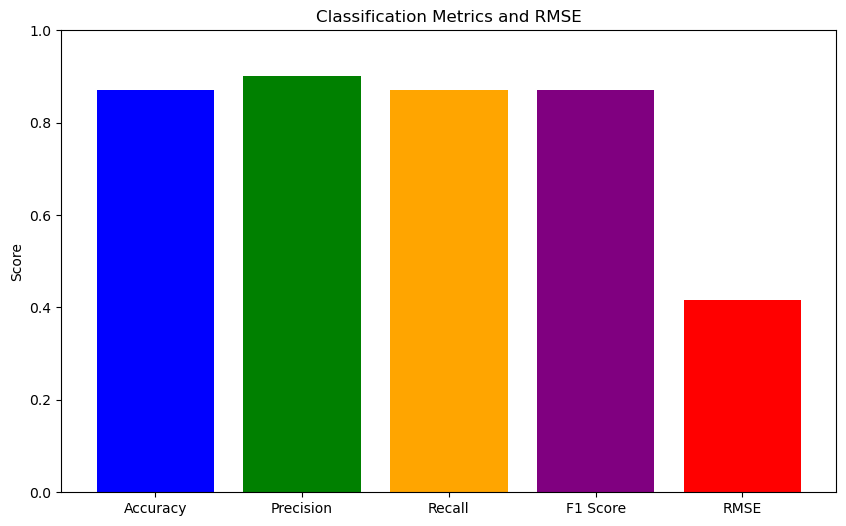

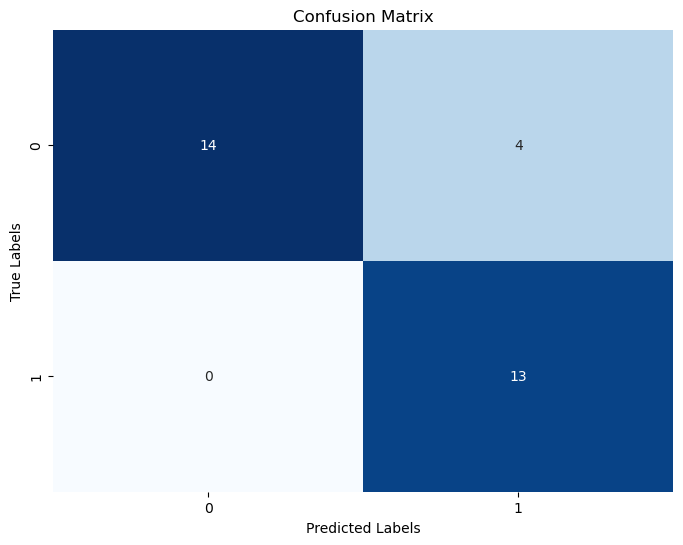

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, confusion_matrix
import numpy as np
import seaborn as sns

# Convert class probabilities to predicted class labels
predicted_labels = np.argmax(combined_values, axis=1)

# Get the true labels from the test set
true_labels = np.argmax(y_test4, axis=1)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='weighted')

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='weighted')

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Calculate RMSE (using probabilities or one-hot encoded labels)
rmse = np.sqrt(mean_squared_error(y_test4, combined_values))

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"RMSE: {rmse:.4f}")

# Plot the metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'RMSE']
values = [accuracy, precision, recall, f1, rmse]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'purple', 'red'])
plt.title('Classification Metrics and RMSE')
plt.ylabel('Score')
plt.ylim(0, 1)  # Set y-axis limits for better visualization (except RMSE if it's high)
plt.show()

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Accuracy: 0.8710
Precision: 0.9013
Recall: 0.8710
F1 Score: 0.8715
RMSE: 0.4163
AUC: 0.7735


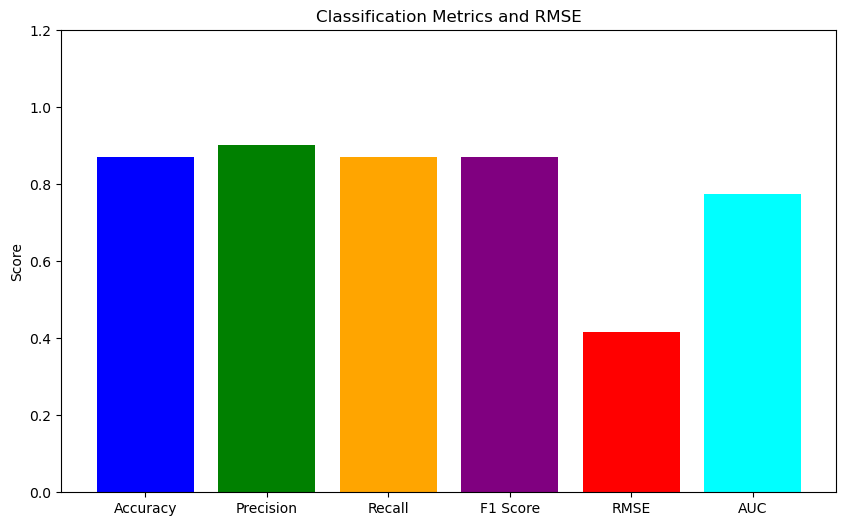

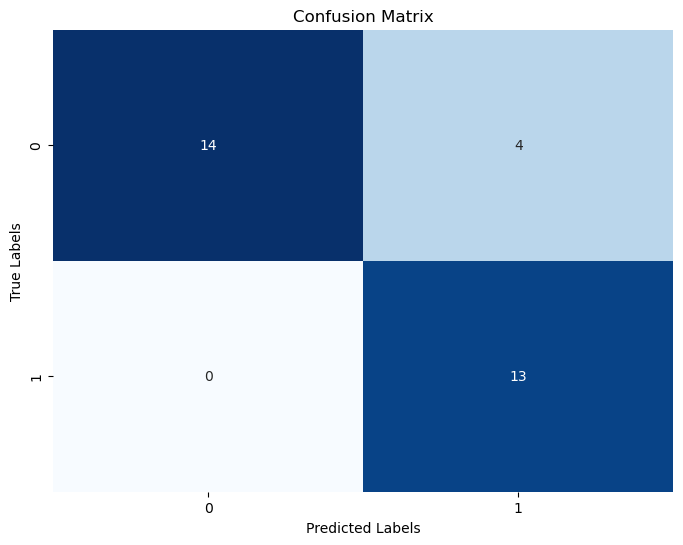

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    mean_squared_error,
    confusion_matrix,
    roc_auc_score
)
import numpy as np
import seaborn as sns

# Convert class probabilities to predicted class labels
predicted_labels = np.argmax(combined_values, axis=1)

# Get the true labels from the test set
true_labels = np.argmax(y_test4, axis=1)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='weighted')

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='weighted')

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Calculate RMSE (using probabilities or one-hot encoded labels)
rmse = np.sqrt(mean_squared_error(y_test4, combined_values))

# Calculate AUC for multi-class
try:
    auc = roc_auc_score(y_test4, combined_values, multi_class='ovr', average='weighted')
except ValueError:
    auc = None  # Handle cases where AUC cannot be calculated (e.g., single class in y_test4)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"RMSE: {rmse:.4f}")
if auc is not None:
    print(f"AUC: {auc:.4f}")
else:
    print("AUC: Unable to calculate (check class balance in y_test4).")

# Plot the metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'RMSE']
values = [accuracy, precision, recall, f1, rmse]

if auc is not None:
    metrics.append('AUC')
    values.append(auc)

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'purple', 'red', 'cyan'])
plt.title('Classification Metrics and RMSE')
plt.ylabel('Score')
plt.ylim(0, 1.2)  # Adjust y-axis limits for better visualization
plt.show()

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [45]:
print(true_labels)
print(predicted_labels)

[0 1 1 0 0 0 1 0 0 0 0 0 1 1 1 0 1 0 0 0 1 1 0 1 0 1 0 1 0 0 1]
[0 1 1 0 0 0 1 1 0 0 0 1 1 1 1 1 1 0 0 0 1 1 0 1 1 1 0 1 0 0 1]


In [46]:

# STEP 6: Calculate and print accuracy for each stored model on test data
print("\nTest Accuracy for Each Architecture and Initializer:")
for architecture, initializers_dict in best_models.items():
    print(f"\n{architecture} Test Accuracy:")
    for initializer, model in initializers_dict.items():
        y_pred = np.argmax(model.predict(X_test4.values[..., np.newaxis] if '1D_CNN' in architecture else X_test4, verbose=0), axis=1)
        accuracy = accuracy_score(np.argmax(y_test4, axis=1), y_pred)
        print(f"Initializer: {initializer} - Accuracy: {accuracy:.4f}")


Test Accuracy for Each Architecture and Initializer:

CNN_DENSE_MAX Test Accuracy:
Initializer: he_normal - Accuracy: 0.8387
Initializer: glorot_uniform - Accuracy: 0.8710
Initializer: lecun_normal - Accuracy: 0.9355
Initializer: he_uniform - Accuracy: 0.9355
Initializer: lecun_uniform - Accuracy: 0.8710
Initializer: glorot_normal - Accuracy: 0.8065
Initializer: orthogonal - Accuracy: 0.8065
Initializer: random_normal - Accuracy: 0.9032
Initializer: random_uniform - Accuracy: 0.9032
Initializer: truncated_normal - Accuracy: 0.9355

ANN_DROPOUT Test Accuracy:
Initializer: he_normal - Accuracy: 0.9032
Initializer: glorot_uniform - Accuracy: 0.9355
Initializer: lecun_normal - Accuracy: 0.9355
Initializer: he_uniform - Accuracy: 0.8065
Initializer: lecun_uniform - Accuracy: 0.8710
Initializer: glorot_normal - Accuracy: 0.8710
Initializer: orthogonal - Accuracy: 0.9355
Initializer: random_normal - Accuracy: 0.8710
Initializer: random_uniform - Accuracy: 0.9355
Initializer: truncated_normal

In [47]:


# STEP 7: Find and print the best initializer and accuracy for each architecture
print("\nBest Initializer and Accuracy for Each Architecture:")
for architecture, initializers_dict in best_models.items():
    best_initializer = None
    best_accuracy = 0
    for initializer, model in initializers_dict.items():
        y_pred = np.argmax(model.predict(X_test4.values[..., np.newaxis] if '1D_CNN' in architecture else X_test4, verbose=0), axis=1)
        accuracy = accuracy_score(np.argmax(y_test4, axis=1), y_pred)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_initializer = initializer
    print(f"{architecture}: Best Initializer - {best_initializer}, Accuracy - {best_accuracy:.4f}")



Best Initializer and Accuracy for Each Architecture:
CNN_DENSE_MAX: Best Initializer - lecun_normal, Accuracy - 0.9355
ANN_DROPOUT: Best Initializer - glorot_uniform, Accuracy - 0.9355
CNN_DENSE_avg: Best Initializer - glorot_uniform, Accuracy - 0.9355
CNN_AVG: Best Initializer - glorot_uniform, Accuracy - 0.9355
1D_CNN: Best Initializer - glorot_uniform, Accuracy - 0.9355


In [38]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Dictionary to store class probabilities across architectures and initializers
average_class_probs = []

print("\nClass Probabilities for Each Architecture and Initializer:")
for architecture, initializers_dict in best_models.items():
    print(f"\n{architecture} Class Probabilities:")
    for initializer, model in initializers_dict.items():
        # Predict class probabilities
        test_probs = model.predict(X_test4.values[..., np.newaxis] if '1D_CNN' in architecture else X_test4, verbose=1)
        
        # Store the probabilities
        average_class_probs.append(test_probs)

        # Print probabilities for this initializer
        print(f"\nInitializer: {initializer}")
        print(pd.DataFrame(test_probs.round(4), columns=[f'Class {i+1}' for i in range(output_size)]))

# Calculate average class probabilities across all architectures and initializers
average_class_probs = np.mean(np.array(average_class_probs), axis=0)

# Display average probabilities
print("\nAverage Class Probabilities Across Architectures and Initializers:")
print(pd.DataFrame(average_class_probs.round(4), columns=[f'Class {i+1}' for i in range(output_size)]))

# Derive predicted labels based on average probabilities
predicted_labels = np.argmax(average_class_probs, axis=1)
true_labels = np.argmax(y_test4, axis=1) # Assuming y_test4 is the true labels

# Calculate performance metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print performance metrics
print("\nPerformance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



Class Probabilities for Each Architecture and Initializer:

CNN_DENSE_MAX Class Probabilities:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Initializer: he_normal
    Class 1  Class 2
0    1.0000   0.0000
1    1.0000   0.0000
2    0.0000   1.0000
3    0.8319   0.1681
4    0.9885   0.0115
5    0.9997   0.0003
6    0.0000   1.0000
7    0.0002   0.9998
8    0.9971   0.0029
9    0.9932   0.0068
10   1.0000   0.0000
11   0.0000   1.0000
12   0.0000   1.0000
13   0.0000   1.0000
14   0.0000   1.0000
15   1.0000   0.0000
16   0.7862   0.2138
17   1.0000   0.0000
18   0.9999   0.0001
19   0.9992   0.0008
20   0.0000   1.0000
21   0.4582   0.5418
22   0.9982   0.0018
23   0.0102   0.9898
24   0.0858   0.9142
25   0.0000   1.0000
26   1.0000   0.0000
27   0.0000   1.0000
28   1.0000   0.0000
29   1.0000   0.0000
30   0.0000   1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

Initializer: glorot_uniform
    Class 1  Class 2
0    0.9121   0.0879
1    0.9503   0.0497
2    0.0745   0.9255
3    0.7129   0.287

In [52]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
#from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Generate data
#X, y = make_classification(n_samples=1000, n_features=20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_500, y, test_size=0.3, random_state=42)
y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

# Train AdaBoost Classifier
base_model = DecisionTreeClassifier(max_depth=1)
model = AdaBoostClassifier(base_model, n_estimators=50, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


/Applications/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.9032258064516129


In [40]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

import numpy as np

# Convert from one-hot encoding to class labels
#y_train4 = np.argmax(y_train4, axis=1)
#y_test4 = np.argmax(y_test4, axis=1)

# Train Bagging Classifier
base_model = DecisionTreeClassifier()
model = BaggingClassifier(base_model, n_estimators=50, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.8571428571428571


In [ ]:
from xgboost import XGBClassifier
#from sklearn.ensemble import xgboost

# Train XGBoost Classifier
model = XGBClassifier(n_estimators=10, random_state=42, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


/Applications/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:58:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9047619047619048


In [22]:
from sklearn.ensemble import GradientBoostingClassifier

# Train Gradient Boosting Classifier
model = GradientBoostingClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.9047619047619048


/Applications/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


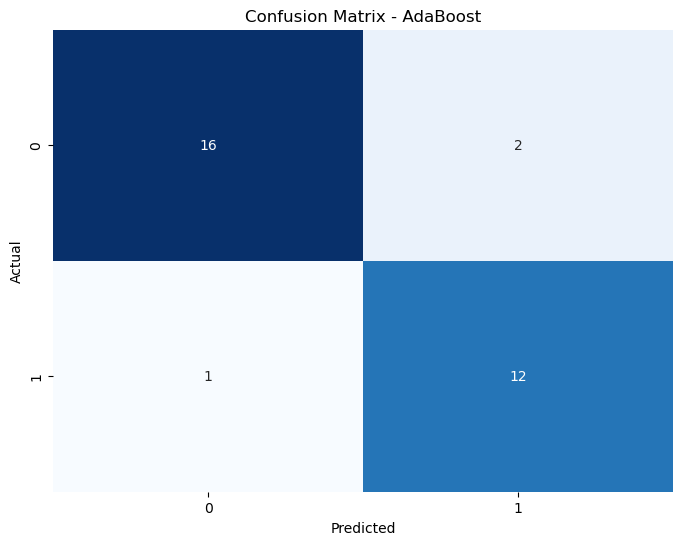

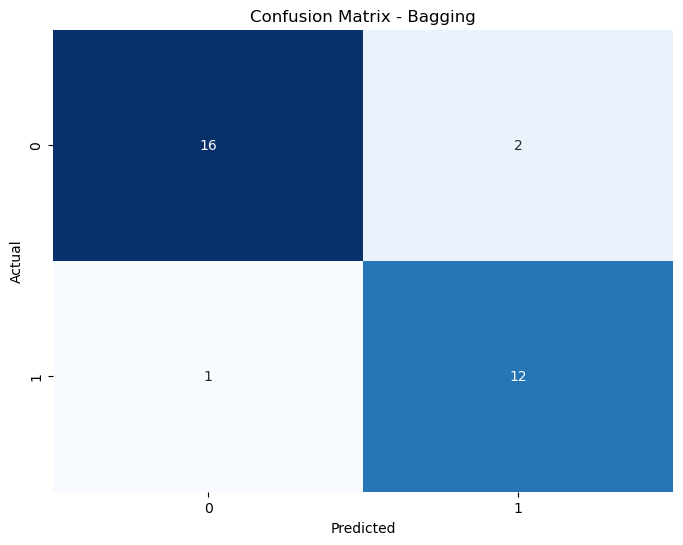

/Applications/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:26:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


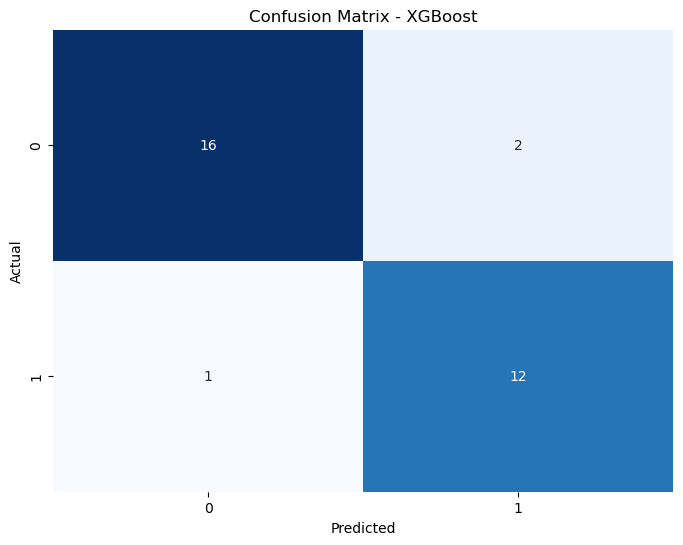

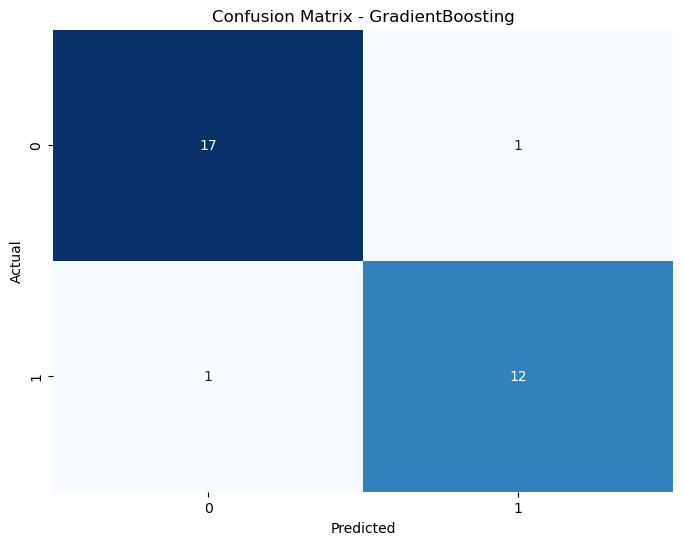

                     Model  Accuracy  Precision    Recall  F1 Score       AUC
0                 AdaBoost  0.903226   0.905937  0.903226  0.903635  0.948718
1                  Bagging  0.903226   0.905937  0.903226  0.903635  0.952991
2                  XGBoost  0.903226   0.905937  0.903226  0.903635  0.976496
3         GradientBoosting  0.935484   0.935484  0.935484  0.935484  0.914530
4  Ensemble w/ Uncertainty  0.967700   0.970000  0.967700  0.967900       NaN


<Figure size 1200x600 with 0 Axes>

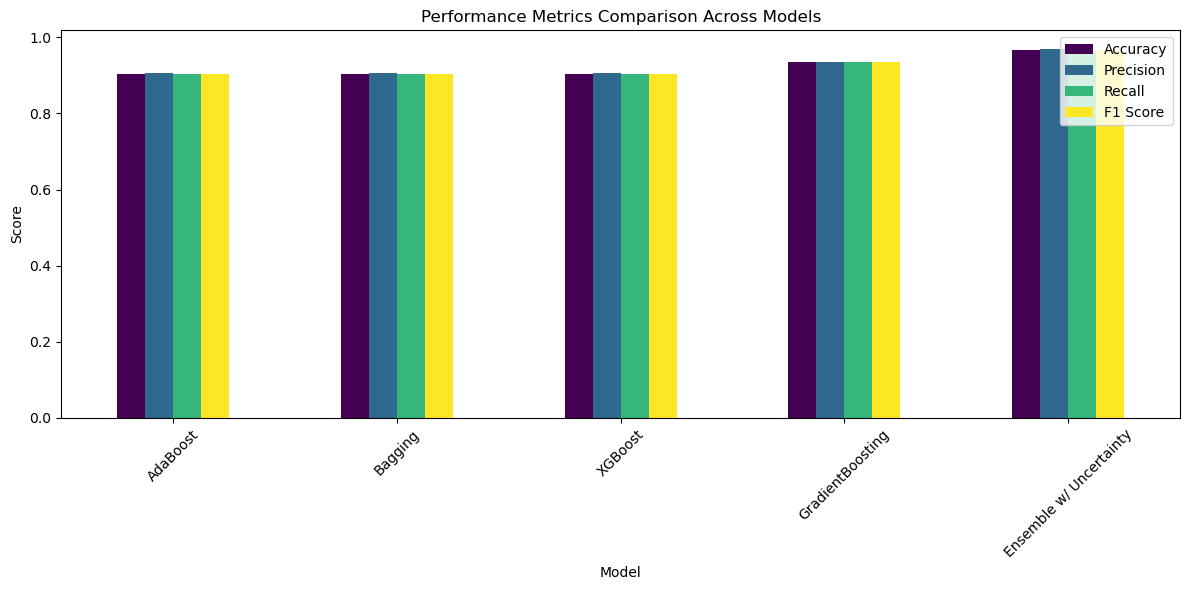

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    mean_squared_error,
    roc_auc_score,
    confusion_matrix
)
import pandas as pd
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    GradientBoostingClassifier
)
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

# List of models
models = [
    ("AdaBoost", AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=50, random_state=42)),
    ("Bagging", BaggingClassifier(DecisionTreeClassifier(), n_estimators=50, random_state=42)),
    ("XGBoost", XGBClassifier(n_estimators=10, random_state=42, use_label_encoder=False, eval_metric='logloss')),
    ("GradientBoosting", GradientBoostingClassifier(n_estimators=100, random_state=42))
]

# Results storage
metrics = []

# Iterate over models
for name, model in models:
    # Train model
    model.fit(X_train, y_train)
    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    # Metrics calculations
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # AUC calculation
    try:
        auc = roc_auc_score(pd.get_dummies(y_test), y_prob, multi_class='ovr', average='weighted')
    except ValueError:
        auc = None  # Handle cases where AUC cannot be calculated

    metrics.append([name, acc, precision, recall, f1, auc])

    # Plot confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Add ensemble uncertainty results manually
metrics.append(["Ensemble w/ Uncertainty", 0.9677, 0.9700, 0.9677, 0.9679, None])

# Create a DataFrame for easy manipulation
metrics_df = pd.DataFrame(metrics, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC"])

# Print the metrics DataFrame
print(metrics_df)

# Plot metrics for all models
plt.figure(figsize=(12, 6))
metrics_df.set_index("Model").drop(columns=["AUC"]).plot(kind="bar", figsize=(12, 6), colormap="viridis")
plt.title("Performance Metrics Comparison Across Models")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [54]:
print(metrics_df)

                     Model  Accuracy  Precision    Recall  F1 Score       AUC
0                 AdaBoost  0.903226   0.905937  0.903226  0.903635  0.948718
1                  Bagging  0.903226   0.905937  0.903226  0.903635  0.952991
2                  XGBoost  0.903226   0.905937  0.903226  0.903635  0.976496
3         GradientBoosting  0.935484   0.935484  0.935484  0.935484  0.914530
4  Ensemble w/ Uncertainty  0.967700   0.970000  0.967700  0.967900       NaN


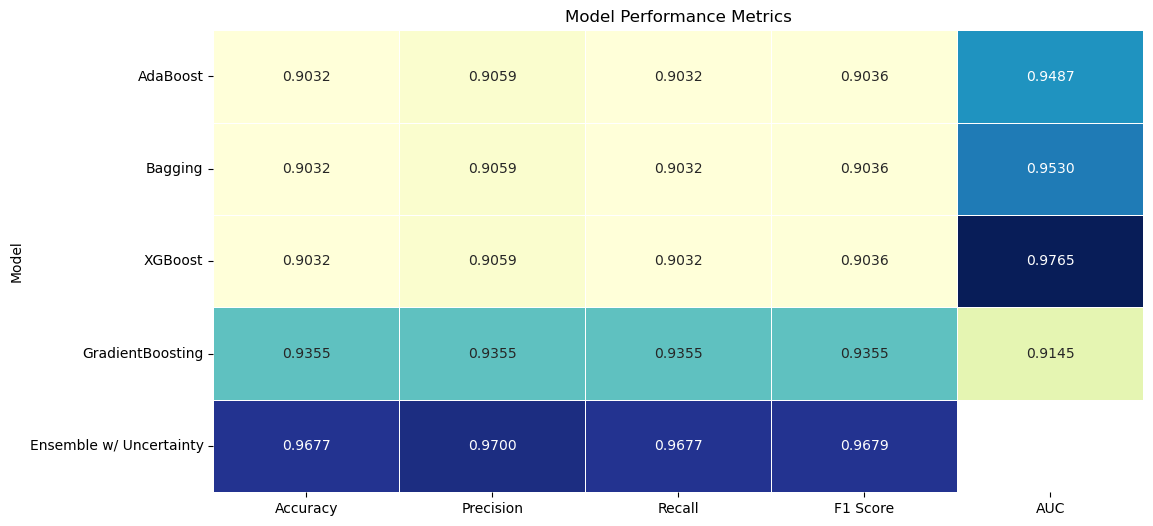

In [55]:
# Display table as a heatmap
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(
    metrics_df.set_index("Model"),
    annot=True,
    fmt=".4f",
    cmap="YlGnBu",
    #cmap='Blues',
    cbar=False,
    linewidths=0.5,
    #ax=ax
)
ax.set_title("Model Performance Metrics")
plt.show()


/Applications/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 30s 117ms/step - accuracy: 0.5239 - loss: 0.9638
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7482 - loss: 0.5546
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.8819 - loss: 0.3617
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7811 - loss: 0.4808 
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8702 - loss: 0.3555 
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8397 - loss: 0.4326
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8749 - loss: 0.3381 
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9070 - loss: 0.1855
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8249 - loss: 0.3659
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8858 - loss: 0.3781 
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.6114 - loss: 0.6813
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7443 - loss: 0.

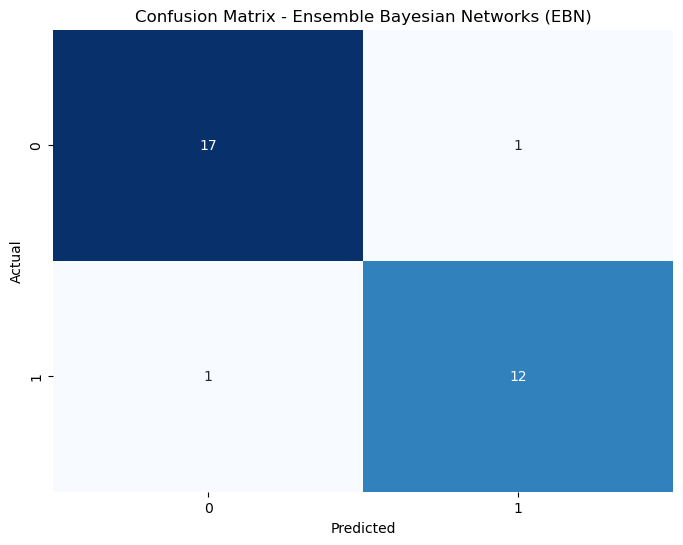

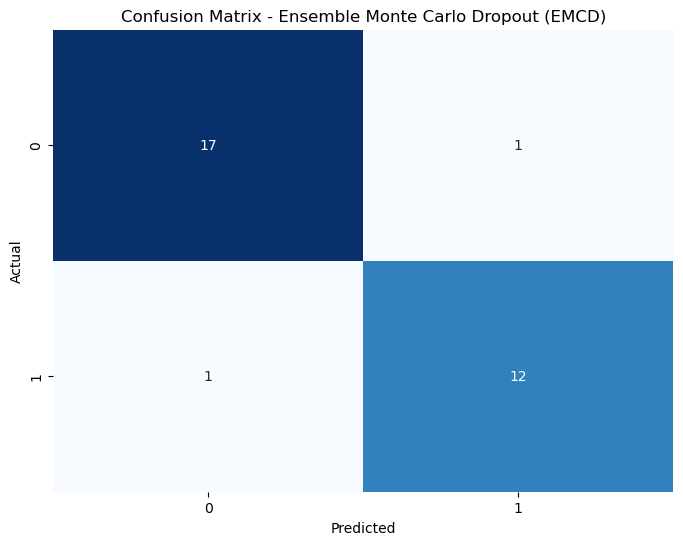

Ensemble Bayesian Networks (EBN):
Accuracy: 0.9355
Precision: 0.9231
Recall: 0.9231
F1 Score: 0.9231
RMSE: 0.2652
AUC: 0.9444

Ensemble Monte Carlo Dropout (EMCD):
Accuracy: 0.9355
Precision: 0.9231
Recall: 0.9231
F1 Score: 0.9231
RMSE: 0.2652
AUC: 0.9444



In [56]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    mean_squared_error,
    confusion_matrix,
    roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# Function to create a model
def create_model(input_dim, dropout_rate=0.5):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Generate synthetic dataset (replace with real dataset)
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

#X, y = make_classification(n_samples=1000, n_features=20, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an ensemble of models for EBN
ensemble_size = 5
models_ebn = [create_model(X_train.shape[1]) for _ in range(ensemble_size)]

# Train each model in the ensemble
for model in models_ebn:
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Ensemble Bayesian Networks (EBN)
def ensemble_bayesian_networks(models, X):
    predictions = [model.predict(X, verbose=0) for model in models]
    mean_prediction = np.mean(predictions, axis=0)
    return mean_prediction

# EMCD - Ensemble Monte Carlo Dropout
def emcd_predictions(models, X, dropout_iterations=10):
    ensemble_predictions = []
    for model in models:
        mc_dropout_preds = []
        for _ in range(dropout_iterations):
            mc_dropout_preds.append(model.predict(X, verbose=0))
        ensemble_predictions.append(np.mean(mc_dropout_preds, axis=0))
    return np.mean(ensemble_predictions, axis=0)

# Predictions for both methods
y_pred_ebn_prob = ensemble_bayesian_networks(models_ebn, X_test)
y_pred_emcd_prob = emcd_predictions(models_ebn, X_test, dropout_iterations=10)

# Convert probabilities to binary predictions
y_pred_ebn = (y_pred_ebn_prob > 0.5).astype(int)
y_pred_emcd = (y_pred_emcd_prob > 0.5).astype(int)

# Function to plot confusion matrix
def plot_confusion_matrix(true_labels, predicted_labels, model_name):
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Calculate AUC and Plot Confusion Matrix for EBN
auc_ebn = roc_auc_score(y_test, y_pred_ebn_prob)
plot_confusion_matrix(y_test, y_pred_ebn, "Ensemble Bayesian Networks (EBN)")

# Calculate AUC and Plot Confusion Matrix for EMCD
auc_emcd = roc_auc_score(y_test, y_pred_emcd_prob)
plot_confusion_matrix(y_test, y_pred_emcd, "Ensemble Monte Carlo Dropout (EMCD)")

# Metrics Display for EBN
print("Ensemble Bayesian Networks (EBN):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_ebn):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_ebn):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_ebn):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_ebn):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_ebn_prob)):.4f}")
print(f"AUC: {auc_ebn:.4f}\n")

# Metrics Display for EMCD
print("Ensemble Monte Carlo Dropout (EMCD):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_emcd):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_emcd):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_emcd):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_emcd):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_emcd_prob)):.4f}")
print(f"AUC: {auc_emcd:.4f}\n")
